# Calibrating the IFT Cloud Mask
The goal with the cloud clearing algorithm is to filter out areas where the cloud cover is too thick for any ice to be retrieved. This is a two-step process with multiple adjustable parameters: first all cloudy pixels are selected and added to the mask, then cloudy pixels that are likely to have visible ice are removed from the mask. Both steps use thresholds for intensity values from band 7 and band 2 of the MODIS false color imagery (7-2-1). The true color imagery can also be helpful, which includes bands 1-4-3. The algorithm is equivalent to production of a bifurcation of the Band 2 to Band 7 color reflectance plane.

Let the intensity value of band $i$ be given by $B_i$. The module then creates a binary mask with the following steps:
1. $A \gets $ Pixels with $B_7 > 110 = \tau_{init}$.
2. $B \gets $ Pixels with $B_7 < 200 = \tau_7$ and $B_2 > 190 = \tau_2$.
3. $C \gets$ Pixels with $B_7/B_2 < 0.75 = \tau_{7:2}$.
4. All clouds $\gets A$
5. Opaque clouds $\gets A \setminus (B \cap C)$

This algorithm is defined in Lopez-Acosta et al. 2019, with somewhat ambiguous wording regarding how sets $B$ and $C$ should be included. The algorithm defines a parameterized piecewise linear function partitioning B7 vs B2 space, with pixel reflectances on one side of the line classified as clouds, and on the other as cloud free (or thin cloud with sea ice). For the updated version of the software, we have the option to either set new parameters for the LA2019 algorithm, or to develop a new version. For example, replacing step 5 by
$$ \text{Opaque clouds} \gets A \setminus (B \cup C) $$
changes the shape of the curve substantially (while being just as consistent with the description in the LA2019 paper).

## Updating the parameter choices
The cloud mask algorithm is quite flexible. As I'll show later on, there are a variety of curves that can be chosen for the algorithm.  We use the Sea Ice Floe Validation Dataset to get information on the pixel intenstities for cloudy, clear-sky ice, and cloudy-sky ice pixels, and use the histograms derived from the pixel intensities to determine the cloud mask settings. We visualize the initial algorithm and the candidate strict and permissive cloud masks over the histograms of training data, then compute the confusion matrices using the held-out data.

## Visualization and data presentation
* Confusion matrix using the 1/3 held-out data
* 

We select 2/3 of the cases at random as the training dataset. 






To this subset, we apply $k$-fold cross validation, optimizing the choice of cloud threshold across $T_C = 0, 10, 20, \cdots, 200$. After computing RMSE for each choice of $T_C$, we find a best-fit quadratic interpolant and find the minimizing integer value of $T_C$. The optimal choice of $T_C$ is the average across the $k$ folds. We also report the mean $RMSE$ across the $k$ folds. Finally, we calculate the error in the cloud fraction relative to the remaining 1/3 of the data. 

This method performs fairly well against the manual (20% error) and the MODIS (10% error) datasets.

## Updated thoughts and planning for this part
1. It is obvious from examination of the images in "cf_mask" that a simple threshold on band 7 is not enough. It does do pretty well in some cases, but it is prone to error when there is land in the image, and when there is a mixture of ice and water pixels.
2. Based on my reading of the papers developing MODIS cloud and ice datasets, there are challenges with the cloud mask based on using a 25 km grid for sea ice cover in choosing how to apply the cloud algorithm. It uses different values for the ice and snow surfaces than for ocean and land surfaces. So direct comparison with the MODIS clouds will also have some errors.
3. As with other terms, joint measures are useful.

## Setup

In [1]:
import numpy as np
import os
import pandas as pd
import proplot as pplt
import rasterio as rio
from rasterio.plot import reshape_as_image
from sklearn.model_selection import KFold
from scipy.interpolate import interp1d

# preliminaries
region_order = ['greenland_sea', 'barents_kara_seas', 'laptev_sea', 'sea_of_okhostk',
                'east_siberian_sea', 'bering_chukchi_seas', 'beaufort_sea', 'hudson_bay', 'baffin_bay']

title_case = {'baffin_bay': 'Baffin Bay',
              'barents_kara_seas': 'Barents-Kara Seas',
              'beaufort_sea': 'Beaufort Sea',
              'bering_chukchi_seas': 'Bering-Chukchi Seas',
              'east_siberian_sea': 'East Siberian Sea',
              'greenland_sea': 'Greenland Sea',
              'hudson_bay': 'Hudson Bay',
              'laptev_sea': 'Laptev Sea',
              'sea_of_okhostk': 'Sea of Okhostk'}

# load the list of cloud clearing evaluation cases
dataloc = '../../ice_floe_validation_dataset/'
df = pd.read_csv(dataloc + '/data/validation_dataset/validation_dataset.csv')
df['case_number'] = [str(cn).zfill(3) for cn in df['case_number']]
df.groupby('region').count()
df['start_date'] = pd.to_datetime(df['start_date'].values)
df.index = [cn + '_' + sat for cn, sat in zip(df.case_number, df.satellite)]

# Divide into testing and training datasets
training_idx = df.sample(frac=2/3, random_state=97234).sort_index().index
df['training'] = False
df.loc[training_idx, 'training'] = True

/opt/miniconda3/envs/calval/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Available forms of the cloud mask algorithm

In [215]:
import warnings
warnings.simplefilter("ignore")
T1 = 190
T2 = 200
R_lower = 0
R_upper = 0.75
tc = 110

def cloud_mask(b2, b7, t0=110, t_b7=200, t_b2=190, t_b7b2=0.75):
    """Cloud mask from the band-level data"""
    step_1 = b7 > t0
    step_2 = b7 < b2*t_b7b2
    step_3 = (b7 < t_b7) & (b2 > t_b2)
    return step_1 & ~(step_2 | step_3)
    
def generate_masks(fc_image, t0=110,  t7=200, t2=190, r_lower=0, r_upper=0.75, variant="LSW2019"):
    """Generate the all-cloud and opaque-cloud masks. Opaque cloud mask is defined as a subset
    of the all-cloud mask where the ice floes are visible."""
    b7 = fc_image[0,:,:]
    b2 = fc_image[1,:,:]

    clouds_view = b7 > t0 # true == cloudy pixel
    mask_b7b2 = (b7 < t7) & (b2 > t2) # true == thin cloud
    mask_ratio = b7/b2
    mask_cloud_ice = (mask_ratio >= r_lower) & (mask_ratio < r_upper)
    
    if variant == "LSW2019":
        mask_cloud_ice = mask_cloud_ice & mask_b7b2    
    else:
        mask_cloud_ice = mask_cloud_ice | mask_b7b2
        
    cloud_mask = ~(mask_cloud_ice & ~clouds_view)
    return clouds_view, cloud_mask



def draw_mask(t0=110,  t7=200, t2=190, r_lower=0, r_upper=0.75, variant="LSW2019"):
    """Returns list of x/y pairs to plot mask partition curve. r_lower not used at all for now."""
    if variant=="LSW2019":
        intersect_t2 = (t2, r_upper*t2)
        intersect_t7 = (t7/r_upper, t7)
        intersect_t0 = (t0/r_upper, t0)
        # If t7 is below t0, then no other unmasking can happen
        if t7 <= t0:
            # print('Case 1')
            x = [0, 255]
            y = [t0, t0]
            return x, y

        # If t2*r_upper is greater than t7, then the ratio is not used
        elif t2*r_upper >= t7:
            # print('Case 2')
            x = [0, t2, t2, 255]
            y = [t0, t0, t7, t7]
            return x, y

        # If the intersection of t7 and the ratio line is outside the range
        # of pixel intensities, then the t7 threshold is not used.
        elif t7/r_upper >= 255: 
            
            # If the intersection between the ratio and the t2 threshold
            # is below the t0 threshold, we get a three-point line
            if r_upper*t2 <= t0: 
                # print('Case 3')
                x = [0, t0/r_upper, 255]
                y = [t0, t0, 255*r_upper]
                return x, y

            # Otherwise, we get a four-point curve with vertical line at the t2 threshold
            # This is the one used by default. 
            else:
                # print('Case 4')
                x = [0, t2, t2, 255]
                y = [t0, t0, r_upper*t2, 255*r_upper]
                return x, y
                
        # Finally we look at where the t7 threshold matters
        else:

            # If the t2 threshold and the ratio line intersect below the t0
            # threshold, then t2 threshold doesn't do anything and we get
            # a four-point curve with horizontal line set by t7
            if r_upper*t2 <= t0:
                # print('Case 5')
                x = [0, t0/r_upper, t7/r_upper, 255]
                y = [t0, t0, t7, t7]
                return x, y

            # Otherwise, we get the only case where all the thresholds matter.
            else:
                # print('Case 6')
                # Five point curve with vertical and horizontal lines
                x = [0, t2, t2, t7/r_upper, 255]
                y = [t0, t0, r_upper*t2, t7, t7]
                return x, y
        
                # Other possibility: what if t0 = 0?

[0, 255] [75, 75]
[0, 160, 160, 255] [90, 90, 100, 100]


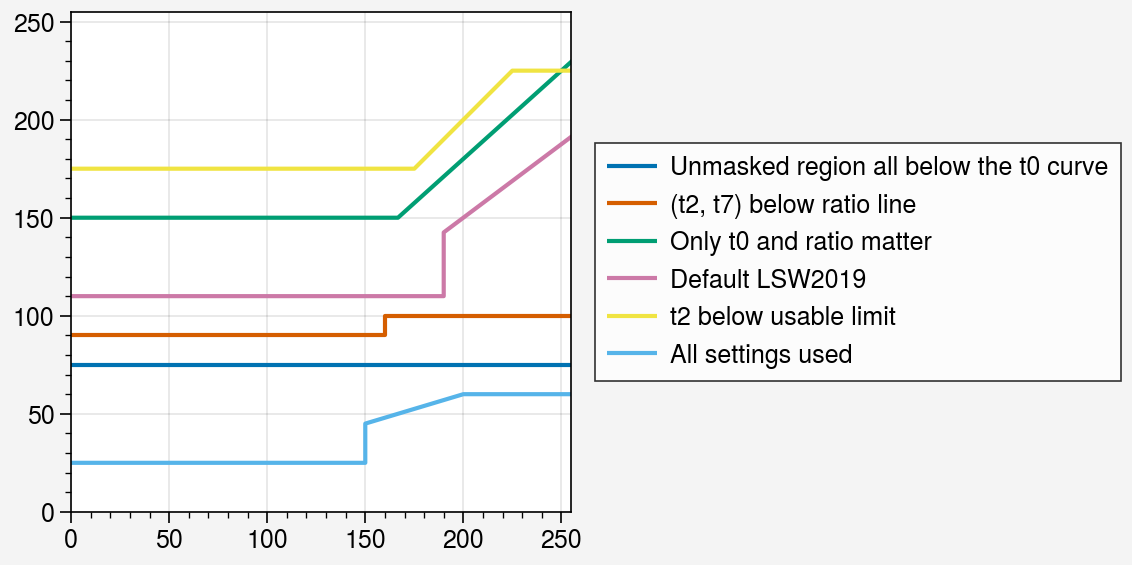

In [3]:
fig, ax = pplt.subplots()

# Case 1
x, y = draw_mask(t7=50, t2=50, t0=75, r_upper=0.4)
print(x, y)
ax.plot(x, y, label='Unmasked region all below the t0 curve')


# Case 2: t2, t7 intersection is below ratio line, ratio is not used.
x, y = draw_mask(t7=100, t2=160, t0=90)
print(x, y)
ax.plot(x, y, label='(t2, t7) below ratio line')

# Case 3 
x, y = draw_mask(t7=255, t2=160, t0=150, r_upper=0.9)
# print(x, y)
ax.plot(x, y, label='Only t0 and ratio matter')

# Case 4: Default settings. Only ratio, t0, and t2 matter.
x, y = draw_mask()
ax.plot(x, y, label='Default LSW2019')

# Case 5: t2 not used, other settings in effect
x, y = draw_mask(t0=175, t2=0, r_upper=1, t7=225)
ax.plot(x, y, label='t2 below usable limit')

# Case 6: All settings used
x, y = draw_mask(t0=25, t2=150, t7=60, r_upper=0.3)
ax.plot(x, y, label='All settings used')


ax.format(ylim=(0, 255), xlim=(0, 255))
ax.legend(ncols=1, loc='r')

# Some to-do items and notes

* Test images: add available masks to the example images.
* Using the "Threshold_CF" images, manually note when the cloud mask appears realiable and when the boundary effect is happening.
* Then we can use the land fast and ice floe images to be the "true ice" data
* Look for cases where we can find clouds past the ice edge to disqualify
* For the cloud fraction data -- our method DOES NOT APPLY to land. It will almost always flag land as cloud. So when we are doing the error analysis it needs to be aligned in that sense, the land needs to be masked out.
* Some images can potentially have a manual water layer based on color thresholding

## Reviewing test images
* 002 - needs landfast ice mask, potentially label floes but its tricky
* 003 - needs landfast ice mask
* 011 - MODIS cloud fraction is wrong (likely edge case -- image is clear)
* 014 - potentially issue with modis mask -- top left looks good, if any clouds are in other sections then they are essentially transparent
* 018 - ambiguous. Possibly transparent clouds, or issue with mask. Nearly clear.
* 021 - alignment with landmask and landfast ice
* 022 - major cloud shadow effects, but cloud fraction seems decent
* 042 - full image is cloudy, the MODIS mask is incorrect
* 059 - need landfast mask, even if no floes visible
* 061 - beautiful image
* 071 - another good example of where manual color thresholding could be used to get an ice/water mask
* 077 - MODIS mask appears agressive - possible transparent cloud or error.
* 088 - either transparent or MODIS error. Example of one where sea ice mask could be made, clouds are super thin.
* 096 - MODIS mask has a clear sky region, looks 100% cloudy to me
* 103 - are those floe labels right? doesn't look right
* 175 - MODIS mask has missing data, likely should be 100% all round
* 179 - possible edge effects, near-transparent clouds

To check the test cases, I can look at the larger region in Worldview to see if the signature of the ice edge error is there.

## Add landfast ice masks even if no floes are visible
This will let us use the landfast ice to train the cloud model, and to test a post-processing routine for getting landfast ice cover.

## Potential to label ice/water for training the ice mask
This could be done image-by-image using histogram thresholding. An example where this could be effective is Case 032. Many images where the sea ice can be easily seen, but would take some work to label.

## ideas for labeling categories
CLEAR_ICE = cloud fraction < min & (landfast | sea ice floes)
CLOUD_ICE = cloud fraction > min & (landfast | sea ice floes)
CLOUD = cloud fraction > min & cloudtype = 'opaque'
CLEAR = cloud fraction < min or cloudtype = 'none'

## setting thresholds
Precision and recall for varying each parameter. Should the different cases be weighted in a particular way?

## Load raster data

In [4]:
def fname(case_data, imtype='labeled_floes'):
    """Generates filenames from rows in the overview table. imtype can be 'labeled_floes', 
    'binary_floes', 'binary_landfast', or 'binary_landmask', 'truecolor', or 'falsecolor'.
    The imtype determines whether a 'png' or 'tiff' is returned.
    """

    cn = case_data['case_number']
    date = pd.to_datetime(case_data['start_date']).strftime('%Y%m%d')
    region = case_data['region']
    sat = case_data['satellite']
    if 'binary' in imtype:
        return  '-'.join([cn, region, date, sat, imtype + '.png'])
        
    elif imtype in ['truecolor', 'falsecolor', 'cloudfraction', 'labeled_floes',]:
        prefix = '-'.join([cn, region, '100km', date])
        return '.'.join([prefix, sat, imtype, '250m', 'tiff'])

    elif imtype in ['seaice', 'landmask',]:
        prefix = '-'.join([cn, region, '100km', date])
        return '.'.join([prefix, 'masie', imtype, '250m', 'tiff'])        

In [5]:
# Load raster data and masks
fc_dataloc = dataloc + 'data/modis/falsecolor/'
tc_dataloc = dataloc + 'data/modis/truecolor/'
cl_dataloc = dataloc + 'data/modis/cloudfraction/'

lm_dataloc = dataloc + 'data/validation_dataset/binary_landmask/'
lb_dataloc = dataloc + 'data/validation_dataset/binary_floes/'
lf_dataloc = dataloc + 'data/validation_dataset/binary_landfast/'

masie_ice_loc = dataloc + 'data/masie/seaice/'
masie_land_loc = dataloc + 'data/masie/landmask/'

tc_images = {}
fc_images = {}
cl_images = {}
lb_images = {}
lf_images = {}
lm_images = {}
mi_images = {}
ml_images = {}

missing = []
for row, data in df.iterrows():
    for datadir, imtype, data_dict in zip([tc_dataloc, fc_dataloc, cl_dataloc,
                                           lb_dataloc, lf_dataloc, lm_dataloc,
                                           masie_ice_loc, masie_land_loc],
                                          ['truecolor', 'falsecolor', 'cloudfraction',
                                           'binary_floes', 'binary_landfast', 'binary_landmask',
                                           'seaice', 'landmask'],
                                          [tc_images, fc_images, cl_images,
                                           lb_images, lf_images, lm_images,
                                           mi_images, ml_images]):
        try:
            with rio.open(datadir + fname(df.loc[row,:], imtype)) as im:
                data_dict[row] = im.read()
        except:
            if imtype in ['falsecolor', 'cloudfraction', 'landmask']:
                print('Couldn\'t read', fname(df.loc[row,:], imtype), imtype)
            elif imtype == 'binary_floes':
                if df.loc[row, 'visible_floes'] == 'yes':
                    missing.append(fname(df.loc[row,:], imtype))
            elif imtype == 'binary_landfast':
                if df.loc[row, 'visible_landfast_ice'] == 'yes':
                    missing.append(fname(df.loc[row,:], imtype))
            elif imtype in ['seaice', 'landmask']: # masie images
                missing.append(fname(df.loc[row,:], imtype))

In [6]:
# Load the numeric cloud fraction data
cf_images = {}
cases = [c for c in cl_images]
cases.sort()

# Make the index of the df a unique case label
df.index = [x.case_number + '_' + x.satellite for row, x in df.iterrows()]

# Loading from file
cf_images = {}
for case in df.index:
    file = fname(df.loc[case], 'binary_landmask').replace('binary_landmask.png', 'cloudfraction.csv')
    try:
        cf_images[case] = pd.read_csv("../data/cloudfraction_numeric/" + file, index_col=0) 
        cf_images[case].index = cf_images[case].index.astype(int)
        cf_images[case].columns = cf_images[case].columns.astype(int)
    except:
        print(case)

df['cloud_fraction_modis'] = np.nan
for case in cf_images:
    df.loc[case, 'cloud_fraction_modis'] = np.mean(cf_images[case]/100)

In [7]:
# can we add water pixels to this?
bands = ['b1', 'b2', 'b3', 'b4', 'b7']
pixel_data = {'cloudy': {},
              'clearsky_ice': {},
              'cloudy_ice': {},
              'water': {},
              # 'other_ocean_pixels': {}
             }

# initialize
for s in pixel_data:
    for b in bands:
        pixel_data[s][b] = []
    pixel_data[s]['case'] = []

# minimum pixel cloud cover for us to call it "cloudy"
min_cloud_frac = 20 

for row, rowdata in df.iterrows():
    case = '{cn}_{s}'.format(cn=rowdata.case_number, s=rowdata.satellite)
    data = {'b1': tc_images[case][0,:,:],
            'b3': tc_images[case][2,:,:],
            'b2': fc_images[case][1,:,:],
            'b4': tc_images[case][1,:,:],
            'b7': fc_images[case][0,:,:]
           }
    
    # get boolean masks for cloud and land
    modis_cloud = cf_images[case] > min_cloud_frac
    land = np.sum(lm_images[case], axis=0) > 1 # replace with boolean mask in the end
    
    if case in lb_images:
        if rowdata.floe_obscuration in ['none', 'light']:
            ice_floes = lb_images[case][0,:,:] > 0
            fast_ice = lf_images[case][0,:,:] > 0
            # ice_nocloud_pixels = (ice_floes | fast_ice) & ~modis_cloud
            # ice_cloud_pixels = (ice_floes | fast_ice) & modis_cloud                
 
            ice_nocloud_pixels = ice_floes & ~modis_cloud
            ice_cloud_pixels = ice_floes & modis_cloud                

            other_ocean_pixels = ~(ice_floes | fast_ice | land | modis_cloud)
            
            for band in data:
                pixel_data['clearsky_ice'][band].append(data[band][ice_nocloud_pixels])
                pixel_data['cloudy_ice'][band].append(data[band][ice_cloud_pixels])
                # pixel_data['other_ocean_pixels'][band].append(data[band][other_ocean_pixels])
            pixel_data['clearsky_ice']['case'].append([case] * ice_nocloud_pixels.astype(int).sum().sum())
            pixel_data['cloudy_ice']['case'].append([case] * ice_cloud_pixels.astype(int).sum().sum())
            # pixel_data['other_ocean_pixels']['case'].append([case] * other_ocean_pixels.astype(int).sum().sum())

        
    elif rowdata.visible_sea_ice == 'no':
        if rowdata.visible_landfast_ice == 'no': # could relax this and just not include where the landfast ice is
            if rowdata.cloud_category_manual == 'opaque':
                cloud_pixels = modis_cloud & ~land
                for band in data:
                    pixel_data['cloudy'][band].append(data[band][cloud_pixels])
                pixel_data['cloudy']['case'].append([case] * cloud_pixels.astype(int).sum().sum())

    if np.mean(modis_cloud & ~land) < 0.75:
        # flag potential water pixels using band 1 intensity
        # Makynen et al. use 25.5 as their threshold (R=0.1 = 25.5/255)
        water_no_cloud_pixels = ~land & ~modis_cloud & (data['b1'] < 26)
        for band in data:
            pixel_data['water'][band].append(data[band][water_no_cloud_pixels])
        pixel_data['water']['case'].append([case] * water_no_cloud_pixels.astype(int).sum().sum())

for s in pixel_data:
    for b in bands:
        pixel_data[s][b] = np.hstack(pixel_data[s][b]).astype(float)
    pixel_data[s]['b7b2'] = pixel_data[s]['b7'] / pixel_data[s]['b2']
    pixel_data[s]['case'] = np.hstack(pixel_data[s]['case'])
    pixel_data[s] = pd.DataFrame(pixel_data[s])
    pixel_data[s]['training'] = df.loc[pixel_data[s]['case'], 'training'].values
    

#



Marg. Method (5%): $\tau_0=53, \tau_2=147.0, \tau_7=130.0, \tau_R=0.62$
Marg. Method (Unmasking): $\tau_0=53, \tau_2=169.0, \tau_7=157.0, \tau_R=0.76$
Marg. Method (Hybrid): $\tau_0=53, \tau_2=169.0, \tau_7=130.0, \tau_R=0.53$


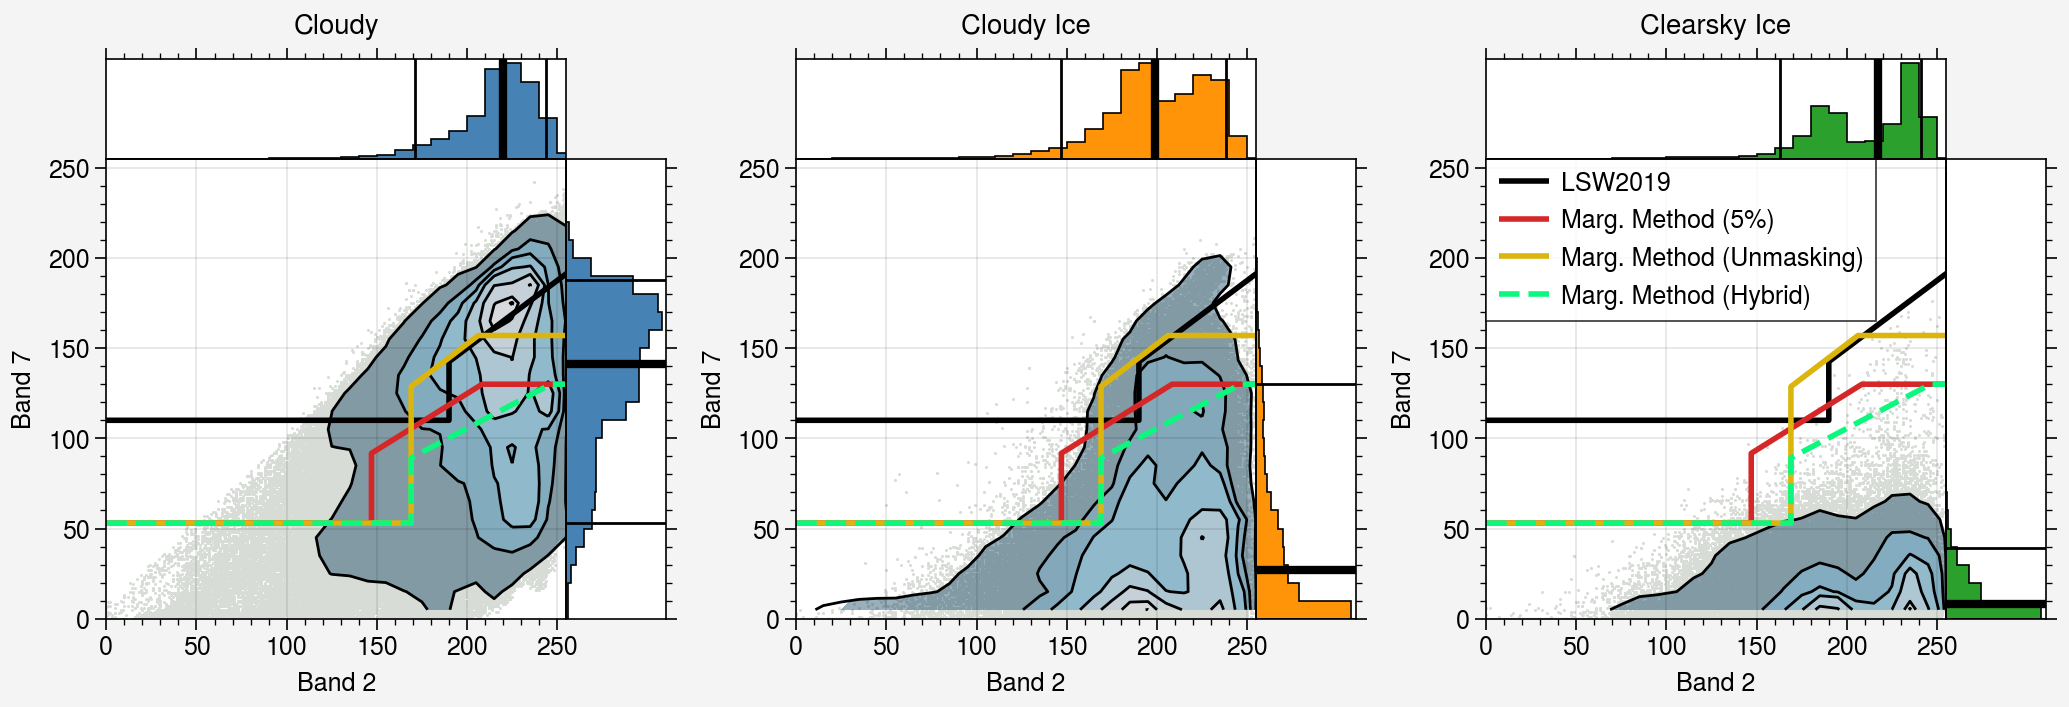

In [8]:
# Histogram with marginal distributions
from scipy.interpolate import interp1d


fig, axs = pplt.subplots(ncols=3, refwidth=2.3, share=False)

for ax, category, color in zip(axs, ['cloudy', 'cloudy_ice', 'clearsky_ice'], ['steelblue', 'tangerine', 'tab:green']):

    idx = pixel_data[category].training
    x = pixel_data[category].loc[idx, 'b2']
    y = pixel_data[category].loc[idx, 'b7']
    x.name = 'Band 2' # weirdly the xlabel function isn't working at all
    y.name = 'Band 7'
    
    bins = np.arange(0, 261, 10)
    binc = 0.5*(bins[1:] + bins[:-1])
    H, _, _ = np.histogram2d(x, y, bins=[bins, bins])
    H = H.T

    Hd = H/np.sum(H)
    F = np.linspace(0, np.max(Hd), 50)
    L = [1-np.sum(Hd[Hd > f]) for f in F]
    results = pd.Series(L, index=F)
    results = results.loc[~results.duplicated()]
    
    # pctiles = np.linspace(0, 1, 11)
    # levels = np.quantile(np.ravel(H)[np.ravel(H) > 0], np.linspace(0, 1, 11))
    # idx2 = levels > 0
    # print(pctiles[idx2])
    # levels = levels[idx2]
    pct = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]
    levels = interp1d(results, results.index)(pct)
    levels = [x for x in levels] + [np.max(Hd)]
    ax.scatter(x.values, y.values, ms=1, m='.', color='light gray')
    # ax.pcolormesh(binc, binc, np.ma.masked_array(H, H==0), N=10, cmap='PuBu_r')
    ax.contourf(binc, binc, np.ma.masked_array(Hd, Hd == 0),
              levels=levels, cmap='PuBu_r', alpha=0.4)
    #          , colorbar='b', colorbar_kw={'label': 'Count', 'rotation': 45})
    ax.contour(binc, binc, Hd, vmin=0, vmax=np.max(Hd),
               levels=levels, lw=1, color='k')
  
    ax.format(titleabove=True,
              title=category.replace('_', ' ').title(),
              ylim=(0, 255), xlim=(0, 255),
              xlabel='Band 2')
    py = ax.panel('r', space=0)
    py.histh(y, bins, color=color, fill=True, ec='k')

    px = ax.panel('t', space=0)
    px.hist(x, bins, color=color, fill=True, ec='k')
    
    pctiles = [0.05, 0.5, 0.95]
    lwidth = [1, 3, 1]
    for p, l in zip(pctiles, lwidth):
        py.axhline(y.quantile(p), lw=l, color='k')
        px.axvline(x.quantile(p), lw=l, color='k')
        
    py.format(grid=False, xlocator=[], ylabel='Band 7', xlabel='', xreverse=False)
    px.format(grid=False, ylocator=[])


    


for ax in axs:
    tau_init = 110
    tau_b2 = 190
    tau_b7 = 200
    tau_b7b2 = 0.75
    x, y = draw_mask(t0=tau_init, t2=tau_b2, t7=tau_b7, r_upper=tau_b7b2)
    ax.plot(x, y, label='LSW2019', ls='-', lw=2, color='k')

for ax in axs:
    # Example with (5%)
    tau_init = 53
    category = 'cloudy_ice'
    idx = pixel_data[category].training
    x = pixel_data[category].loc[idx, 'b2']
    y = pixel_data[category].loc[idx, 'b7']
    tau_b2 = x.quantile(0.05)
    tau_b7 = y.quantile(0.95)
    r = pixel_data[category].loc[idx, 'b7b2']
    tau_b7b2 = r.quantile(0.95)
    x, y = draw_mask(t0=tau_init, t2=tau_b2, t7=tau_b7, r_upper=tau_b7b2)
    ax.plot(x, y, label='Marg. Method (5%)', ls='-', lw=2, color='tab:red')
print('Marg. Method (5%): $\\tau_0={t0}, \\tau_2={t2}, \\tau_7={t7}, \\tau_R={r}$'.format(t0=tau_init, t2=tau_b2, t7=tau_b7, r=np.round(tau_b7b2, 2)))

for ax in axs:
    # Example using only pixels with b7 > tau_init
    tau_init = 53
    category = 'cloudy_ice'
    idx = pixel_data[category].training & (pixel_data[category]['b7'] >= tau_init)
    x = pixel_data[category].loc[idx, 'b2']
    y = pixel_data[category].loc[idx, 'b7']
    tau_b2 = x.quantile(0.05)
    tau_b7 = y.quantile(0.95)
    r = pixel_data[category].loc[idx, 'b7b2']
    tau_b7b2 = r.quantile(0.95)
    x, y = draw_mask(t0=tau_init, t2=tau_b2, t7=tau_b7, r_upper=tau_b7b2)
    ax.plot(x, y, label='Marg. Method (Unmasking)', ls='-', lw=2, color='gold')    
    ax.format(xlabel='Band 2')
print('Marg. Method (Unmasking): $\\tau_0={t0}, \\tau_2={t2}, \\tau_7={t7}, \\tau_R={r}$'.format(t0=tau_init, t2=tau_b2, t7=tau_b7, r=np.round(tau_b7b2, 2)))

for ax in axs:
    # Example using only pixels with b7 > tau_init
    tau_init = 53
    category = 'cloudy_ice'
    idx = pixel_data[category].training
    idx_b2 = idx & (pixel_data[category]['b7'] >= tau_init)
    x = pixel_data[category].loc[idx_b2, 'b2']
    y = pixel_data[category].loc[idx, 'b7']
    tau_b2 = x.quantile(0.05)
    tau_b7 = y.quantile(0.95)
    idx_r = idx & (pixel_data[category]['b2'] >= tau_b2) & (pixel_data[category]['b7'] <= tau_b7)
    r = pixel_data[category].loc[idx_r, 'b7b2']
    tau_b7b2 = r.quantile(0.95)
    x, y = draw_mask(t0=tau_init, t2=tau_b2, t7=tau_b7, r_upper=tau_b7b2)
    ax.plot(x, y, label='Marg. Method (Hybrid)', ls='--', lw=2, color='mint green')    
    ax.format(xlabel='Band 2')
print('Marg. Method (Hybrid): $\\tau_0={t0}, \\tau_2={t2}, \\tau_7={t7}, \\tau_R={r}$'.format(t0=tau_init, t2=tau_b2, t7=tau_b7, r=np.round(tau_b7b2, 2)))

ax.legend(ncols=1)
fig.save('../figures/cloud_mask_histograms_alt_lines2.png', dpi=300)

In [9]:
# TBD: Add color legend

# Choosing parameters for the cloud mask
The choice of parameters for the ice mask has some freedom, shown by the range of shapes in the prior figure, and some strict limitations. One of the more limiting factors is that the ratio test has to go through the origin -- easily adjusted by adding offset term, but that still would require a deeper update to the code. It's also not exactly obvious where one would want to try and optimize things. So I've looked at a couple methods.

## Marginal distributions
Set a tolerance level for the fraction of the marginal distributions you want to include. That results, though, in a curve that omits some parts of the joint distribution in ways that feel somewhat artificial. An example of how that would work is to say we want to set the initial threshold to include 95\% of the cloudy pixels, so we set it to $\tau_0 = 53 = 95$th percentile for Cloudy B$_7$. Then we can look at trying to mark off 95\% of the cloudy ice pixels. But since this is a 2d distribution, there is not a unique way to do that. Choosing the 95th percentile for B$_7$ and the 5th percentile for $B_2$ leads to thresholds of 149 and 128, and an $R$ value of 0.62.

In [10]:
t0 = 53
category = 'cloudy_ice'
idx = pixel_data[category].training
x = pixel_data[category].loc[idx, 'b2']
y = pixel_data[category].loc[idx, 'b7']
r = pixel_data[category].loc[idx, 'b7b2']
print(x.quantile(0.05), y.quantile(0.95), np.round(r.quantile(0.95), 2))

147.0 130.0 0.62


The performance of this method isn't bad: 

In [11]:
print('Method: 95th Percentiles')
tau_init = 53
category = 'cloudy_ice'
idx = pixel_data[category].training
tau_b2 = pixel_data[category].loc[idx, 'b2'].quantile(0.05)
tau_b7 = pixel_data[category].loc[idx, 'b7'].quantile(0.95)
r = np.round(pixel_data[category].loc[idx, 'b7b2'].quantile(0.95), 2)

# Compare methods with training dataset
c_df = pixel_data['cloudy'].loc[pixel_data['cloudy'].training, :]
ci_df = pixel_data['cloudy_ice'].loc[pixel_data['cloudy_ice'].training, :]
csi_df = pixel_data['clearsky_ice'].loc[pixel_data['clearsky_ice'].training, :]
cloud_ice_original_mask = cloud_mask(ci_df.b2, ci_df.b7)
cloud_ice_new_mask = cloud_mask(ci_df.b2, ci_df.b7, t0=tau_init, t_b7=tau_b7, t_b2=tau_b2, t_b7b2=r)
clearsky_ice_original_mask = cloud_mask(csi_df.b2, csi_df.b7)
clearsky_ice_new_mask = cloud_mask(csi_df.b2, csi_df.b7, t0=tau_init, t_b7=tau_b7, t_b2=tau_b2, t_b7b2=r)

original_mask = cloud_mask(c_df.b2, c_df.b7)
new_mask = cloud_mask(c_df.b2, c_df.b7, t0=tau_init, t_b7=tau_b7, t_b2=tau_b2, t_b7b2=r)
print('True positive rate (cloudy images):',
      np.round(np.mean(original_mask), 2), '(Orig)',
      np.round(np.mean(new_mask), 2), '(New)')

print('False positive rate (cloudy ice): ',
      np.round(np.mean(cloud_ice_original_mask), 2), '(Orig)',
      np.round(np.mean(cloud_ice_new_mask), 2), '(New)')

print('False positive rate (clear-sky ice): ',
      np.round(np.mean(clearsky_ice_original_mask), 2), '(Orig)',
      np.round(np.mean(clearsky_ice_new_mask), 2), '(New)')


print('False positive rate (cloudy ice + clear-sky ice): ',
      np.round(np.mean(pd.concat([cloud_ice_original_mask, clearsky_ice_original_mask])), 2), '(Orig)',
      np.round(np.mean(pd.concat([cloud_ice_new_mask, clearsky_ice_new_mask])), 2), '(New)')

Method: 95th Percentiles
True positive rate (cloudy images): 0.05 (Orig) 0.54 (New)
False positive rate (cloudy ice):  0.0 (Orig) 0.04 (New)
False positive rate (clear-sky ice):  0.0 (Orig) 0.0 (New)
False positive rate (cloudy ice + clear-sky ice):  0.0 (Orig) 0.02 (New)


So in a sense, this is a pretty clear and good result! We've increased the performance for cloudy regions, going from only covering 4\% of cloudy pixels to 55\% of cloudy pixels, at a cost of masking 5\% of the cloud-obscured sea ice pixels. There was no significant change in the number of clear-sky ice pixels covered. Considering both the clear sky and cloudy ice pixels together, we've covered only 1\% of the sea ice pixels in the testing dataset.

One issue with this approach? The majority of the cloudy ice pixels are already set aside by the t0 threshold! Specifically, only 28\% of the cloudy ice pixels have B$_7$ reflectance greater than 53, and 1\% of the clear-sky ice pixels do. So the mask fitting was based on using data that never was covered in the first place.

In [12]:
print('Fraction of cloudy ice pixels masked by Step 1 cloud mask: ', np.round(np.mean(y > tau_init)*100, 1), '%')
idx = pixel_data['clearsky_ice'].training
y2 = pixel_data['clearsky_ice'].loc[idx, 'b7']
print('Fraction of clear-sky ice pixels masked by Step 1 cloud mask: ', np.round(np.mean(y2 > tau_init)*100, 1), '%')

Fraction of cloudy ice pixels masked by Step 1 cloud mask:  28.2 %
Fraction of clear-sky ice pixels masked by Step 1 cloud mask:  1.1 %


If we were to use only the data above that original cloud mask, we could get something like this:

In [13]:
# Example using only pixels with b7 > tau_init
tau_init = 53
category = 'cloudy_ice'
idx = pixel_data[category].training
idx = idx & (pixel_data[category]['b7'] >= tau_init)
x = pixel_data[category].loc[idx, 'b2']
y = pixel_data[category].loc[idx, 'b7']
tau_b2 = x.quantile(0.05)
tau_b7 = y.quantile(0.95)
r = pixel_data[category].loc[idx, 'b7b2']
r = r.quantile(0.95)
print(tau_init, tau_b2, tau_b7, r)

original_mask = cloud_mask(c_df.b2, c_df.b7)
new_mask = cloud_mask(c_df.b2, c_df.b7, t0=tau_init, t_b7=tau_b7, t_b2=tau_b2, t_b7b2=r)
print('True positive rate (cloudy images):', np.round(np.mean(original_mask), 2), '(Orig)', np.round(np.mean(new_mask), 2), '(New)')

cloud_ice_original_mask = cloud_mask(ci_df.b2, ci_df.b7)
cloud_ice_new_mask = cloud_mask(ci_df.b2, ci_df.b7, t0=tau_init, t_b7=tau_b7, t_b2=tau_b2, t_b7b2=r)
clearsky_ice_original_mask = cloud_mask(csi_df.b2, csi_df.b7)
clearsky_ice_new_mask = cloud_mask(csi_df.b2, csi_df.b7, t0=tau_init, t_b7=tau_b7, t_b2=tau_b2, t_b7b2=r)

print('False positive rate (cloudy ice): ',
      np.round(np.mean(cloud_ice_original_mask), 2), '(Orig)',
      np.round(np.mean(cloud_ice_new_mask), 2), '(New)')

print('False positive rate (clear-sky ice): ',
      np.round(np.mean(clearsky_ice_original_mask), 2), '(Orig)',
      np.round(np.mean(clearsky_ice_new_mask), 2), '(New)')


print('False positive rate (cloudy ice + clear-sky ice): ',
      np.round(np.mean(pd.concat([cloud_ice_original_mask, clearsky_ice_original_mask])), 2), '(Orig)',
      np.round(np.mean(pd.concat([cloud_ice_new_mask, clearsky_ice_new_mask])), 2), '(New)')

53 169.0 157.0 0.7614213197969543
True positive rate (cloudy images): 0.05 (Orig) 0.26 (New)
False positive rate (cloudy ice):  0.0 (Orig) 0.01 (New)
False positive rate (clear-sky ice):  0.0 (Orig) 0.0 (New)
False positive rate (cloudy ice + clear-sky ice):  0.0 (Orig) 0.0 (New)


In this case, we still see an improvement with the cloud mask (26\% is better than 4\%!) but only dropped the false positive rate from 4\% to `\%. So this approach degrades the cloud mask performance severely -- 55 down to 26\% -- and only improves the uncovering performance by 3\%. (Depending on how you look at it of course, 1\% is only 25\% of 4\%, but that starts to get silly).

Finally, let's look at a hybrid method: selecting the band 2 threshold based on 95\% of the cloudy ice pixels conditioned on the band 7 reflectance exceeding the initial threshold, but use all the cloudy ice data to set the band 7 unmasking threshold. Then set R using the band 2 and band 7 data where $B_2 > \tau_2$ and $B_7 > \tau_7.$

In [14]:
tau_init = 53
category = 'cloudy_ice'
idx = pixel_data[category].training
idx_b2 = idx & (pixel_data[category]['b7'] >= tau_init)
x = pixel_data[category].loc[idx_b2, 'b2']
y = pixel_data[category].loc[idx, 'b7']
tau_b2 = x.quantile(0.05)
tau_b7 = y.quantile(0.95)
idx_r = idx & (pixel_data[category]['b2'] >= tau_b2) & (pixel_data[category]['b7'] <= tau_b7)
r = pixel_data[category].loc[idx_r, 'b7b2']
r = r.quantile(0.95)
print(tau_init, tau_b2, tau_b7, np.round(r, 2))

original_mask = cloud_mask(c_df.b2, c_df.b7)
new_mask = cloud_mask(c_df.b2, c_df.b7, t0=tau_init, t_b7=tau_b7, t_b2=tau_b2, t_b7b2=r)
print('True positive rate (cloudy images):', np.round(np.mean(original_mask), 2), '(Orig)', np.round(np.mean(new_mask), 2), '(New)')

cloud_ice_original_mask = cloud_mask(ci_df.b2, ci_df.b7)
cloud_ice_new_mask = cloud_mask(ci_df.b2, ci_df.b7, t0=tau_init, t_b7=tau_b7, t_b2=tau_b2, t_b7b2=r)
clearsky_ice_original_mask = cloud_mask(csi_df.b2, csi_df.b7)
clearsky_ice_new_mask = cloud_mask(csi_df.b2, csi_df.b7, t0=tau_init, t_b7=tau_b7, t_b2=tau_b2, t_b7b2=r)

print('False positive rate (cloudy ice): ',
      np.round(np.mean(cloud_ice_original_mask), 2), '(Orig)',
      np.round(np.mean(cloud_ice_new_mask), 2), '(New)')

print('False positive rate (clear-sky ice): ',
      np.round(np.mean(clearsky_ice_original_mask), 2), '(Orig)',
      np.round(np.mean(clearsky_ice_new_mask), 2), '(New)')


print('False positive rate (cloudy ice + clear-sky ice): ',
      np.round(np.mean(pd.concat([cloud_ice_original_mask, clearsky_ice_original_mask])), 2), '(Orig)',
      np.round(np.mean(pd.concat([cloud_ice_new_mask, clearsky_ice_new_mask])), 2), '(New)')

53 169.0 130.0 0.53
True positive rate (cloudy images): 0.05 (Orig) 0.62 (New)
False positive rate (cloudy ice):  0.0 (Orig) 0.05 (New)
False positive rate (clear-sky ice):  0.0 (Orig) 0.0 (New)
False positive rate (cloudy ice + clear-sky ice):  0.0 (Orig) 0.02 (New)


## A note on the level selection for the histogram visualization
We first compute the histogram using bin size 10. These are used to estimate the joint probability distribution using a contour plot. We choose the contours to plot by estimating the percentiles of the joint PDF. These can't be read directly from the density; instead, we need to calculate the integral of the 

From these counts, we can calculate the probability that the data is within a level set $L(f)

estimate the level curves such that the data is above the level curve with probability $P$. Denoting with $F$ the area within the contour at level $f$,  we can compute $L(f)$ by
$$L(f) = \int_{x, y \in F} p(x, y) dxdy $$
This function provides

The contour lines mark the percentiles of the histogram bin counts. 
The contours mark the level sets of the distribution at intervals of 10\%, hence the brightest area in each histogram contour shows where 90\% of the data lies. Dots show individual pixel values from below the 10th percentile. The black line shows the default values of the algorithm based on the Lopez-Acosta, Schodlock, and Wilhelmus 2019 paper (LSW2019). As can be seen, there is a large overlap between the region with clouds and the region with cloud-covered sea ice. Using band 7 and band 2 alone cannot completely separate clouds and ice, 

In [37]:
test = pixel_data['clearsky_ice'].sample(2500)

x = test.b2
y = test.b7
H, _, _ = np.histogram2d(x, y, bins=[bins, bins])
H = H.T

Hd = H/np.sum(H)
Hd = H/np.sum(H)
F = np.linspace(0, np.max(Hd), 50)
L = [1-np.sum(Hd[Hd > f]) for f in F]
results = pd.Series(L, index=F)
results = results.loc[~results.duplicated()]

pct = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]
levels = interp1d(results, results.index)(pct)
levels = [x for x in levels] + [np.max(Hd)]

Marg. Method (Hybrid): $\tau_0=53, \tau_2=169.0, \tau_7=130.0, \tau_R=0.53$


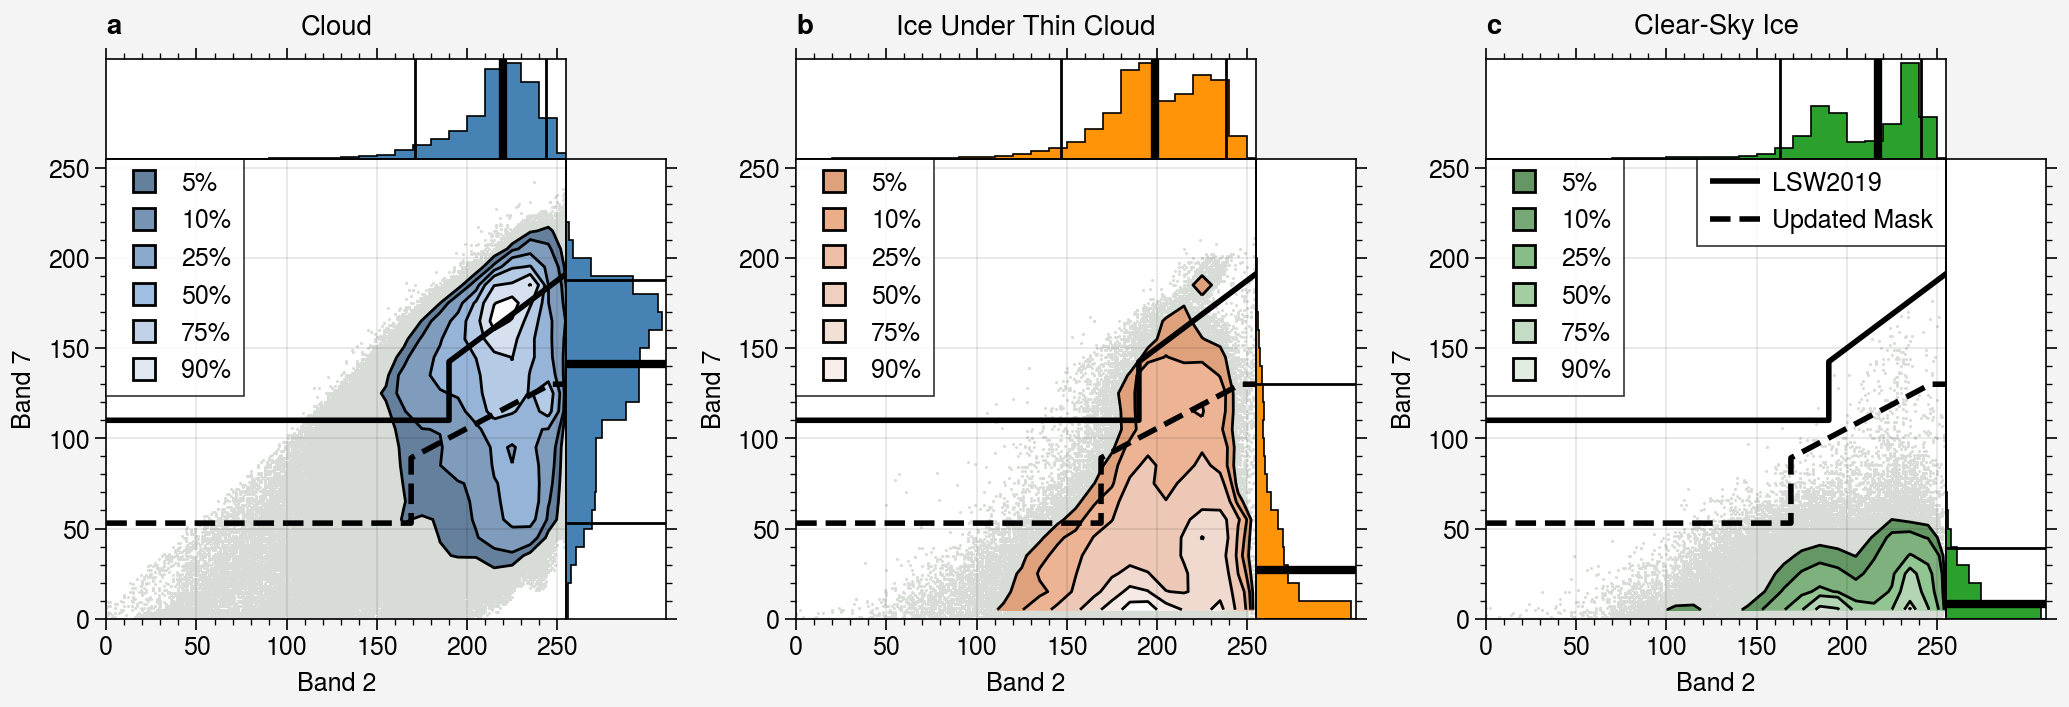

In [155]:
# Histogram with marginal distributions
from scipy.interpolate import interp1d


fig, axs = pplt.subplots(ncols=3, refwidth=2.3, share=False)

for ax, category, color, title in zip(axs, ['cloudy', 'cloudy_ice', 'clearsky_ice'],
                                      ['steelblue', 'tangerine', 'tab:green'],
                                      ['Cloud', 'Ice Under Thin Cloud', 'Clear-Sky Ice']):

    idx = pixel_data[category].training
    x = pixel_data[category].loc[idx, 'b2']
    y = pixel_data[category].loc[idx, 'b7']
    x.name = 'Band 2' # weirdly the xlabel function isn't working at all
    y.name = 'Band 7'
    
    bins = np.arange(0, 261, 10)
    binc = 0.5*(bins[1:] + bins[:-1])
    H, _, _ = np.histogram2d(x, y, bins=[bins, bins])
    H = H.T
    Hd = H/np.sum(H)

    # get plot levels
    F = np.linspace(0, np.max(Hd), 50)
    L = [1-np.sum(Hd[Hd > f]) for f in F]
    results = pd.Series(L, index=F)
    results = results.loc[~results.duplicated()]
    pct = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9]
    levels = interp1d(results, results.index)(pct)
    levels = [x for x in levels] + [np.max(Hd)]
    ax.scatter(x.values, y.values, ms=1, m='.', color='light gray')

    # overlay contours
    cmap1 = pplt.Colormap((color, 'pale gray'), l=100, name='cmap1', space='hpl')
    c = ax.contourf(binc, binc, np.ma.masked_array(Hd, Hd == 0),
              levels=levels, cmap=cmap1, alpha=1, vmin=np.max(Hd), vmax=np.max(Hd))
    ax.contour(binc, binc, Hd, vmin=0, vmax=np.max(Hd),
               levels=levels, lw=1, color='k')

    # create color legend
    h = []
    for colorname in pplt.Cycle(cmap1, 7):
        h.append(ax.plot([], [], color=colorname['color'], m='s', ms=8, edgecolor='k', ew=1, lw=0))
    ax.legend(h, [str(int(p*100)) + '%' for p in pct], ncol=1, order='F', loc='ul', fontsize=8)
    
    ax.format(titleabove=True,
              title=title,
              ylim=(0, 255), xlim=(0, 255),
              xlabel='Band 2')
    py = ax.panel('r', space=0)
    py.histh(y, bins, color=color, fill=True, ec='k')

    px = ax.panel('t', space=0)
    px.hist(x, bins, color=color, fill=True, ec='k')
    
    pctiles = [0.05, 0.5, 0.95]
    lwidth = [1, 3, 1]
    for p, l in zip(pctiles, lwidth):
        py.axhline(y.quantile(p), lw=l, color='k')
        px.axvline(x.quantile(p), lw=l, color='k')
        
    py.format(grid=False, xlocator=[], ylabel='Band 7', xlabel='', xreverse=False)
    px.format(grid=False, ylocator=[])


    
for ax in axs:
    tau_init = 110
    tau_b2 = 190
    tau_b7 = 200
    tau_b7b2 = 0.75
    x, y = draw_mask(t0=tau_init, t2=tau_b2, t7=tau_b7, r_upper=tau_b7b2)
    ax.plot(x, y, label='LSW2019', ls='-', lw=2, color='k')

for ax in axs:
    # Example using only pixels with b7 > tau_init
    tau_init = 53
    category = 'cloudy_ice'
    idx = pixel_data[category].training
    idx_b2 = idx & (pixel_data[category]['b7'] >= tau_init)
    x = pixel_data[category].loc[idx_b2, 'b2']
    y = pixel_data[category].loc[idx, 'b7']
    tau_b2 = x.quantile(0.05)
    tau_b7 = y.quantile(0.95)
    idx_r = idx & (pixel_data[category]['b2'] >= tau_b2) & (pixel_data[category]['b7'] <= tau_b7)
    r = pixel_data[category].loc[idx_r, 'b7b2']
    tau_b7b2 = r.quantile(0.95)
    x, y = draw_mask(t0=tau_init, t2=tau_b2, t7=tau_b7, r_upper=tau_b7b2)
    ax.plot(x, y, label='Updated Mask', ls='--', lw=2, color='k')    
    ax.format(xlabel='Band 2')
print('Marg. Method (Hybrid): $\\tau_0={t0}, \\tau_2={t2}, \\tau_7={t7}, \\tau_R={r}$'.format(t0=tau_init, t2=tau_b2, t7=tau_b7, r=np.round(tau_b7b2, 2)))

ax.legend(ncols=1, loc='ur')
fig.format(abc=True)
fig.save('../figures/cloud_mask_histograms_update.png', dpi=300)

In [221]:
# Using test data:

tau_init = 53
category = 'cloudy_ice'
idx = pixel_data[category].training
idx_b2 = idx & (pixel_data[category]['b7'] >= tau_init)
x = pixel_data[category].loc[idx_b2, 'b2']
y = pixel_data[category].loc[idx, 'b7']
tau_b2 = x.quantile(0.05)
tau_b7 = y.quantile(0.95)
idx_r = idx & (pixel_data[category]['b2'] >= tau_b2) & (pixel_data[category]['b7'] <= tau_b7)
r = pixel_data[category].loc[idx_r, 'b7b2']
r = r.quantile(0.95)
print(tau_init, tau_b2, tau_b7, np.round(r, 2))


# Compare methods with training dataset
c_df = pixel_data['cloudy'].loc[~pixel_data['cloudy'].training, :]
ci_df = pixel_data['cloudy_ice'].loc[~pixel_data['cloudy_ice'].training, :]
csi_df = pixel_data['clearsky_ice'].loc[~pixel_data['clearsky_ice'].training, :]



original_mask = cloud_mask(c_df.b2, c_df.b7)
new_mask = cloud_mask(c_df.b2, c_df.b7, t0=tau_init, t_b7=tau_b7, t_b2=tau_b2, t_b7b2=r)
print('True positive rate (cloudy images):',
      np.round(np.mean(original_mask)*100, 2), '(Orig)',
      np.round(np.mean(new_mask)*100, 2), '(New)')

cloud_ice_original_mask = cloud_mask(ci_df.b2, ci_df.b7)
cloud_ice_new_mask = cloud_mask(ci_df.b2, ci_df.b7, t0=tau_init, t_b7=tau_b7, t_b2=tau_b2, t_b7b2=r)
clearsky_ice_original_mask = cloud_mask(csi_df.b2, csi_df.b7)
clearsky_ice_new_mask = cloud_mask(csi_df.b2, csi_df.b7, t0=tau_init, t_b7=tau_b7, t_b2=tau_b2, t_b7b2=r)

print('False positive rate (cloudy ice): ',
      np.round(np.mean(cloud_ice_original_mask)*100, 2), '(Orig)',
      np.round(np.mean(cloud_ice_new_mask)*100, 2), '(New)')

print('False positive rate (clear-sky ice): ',
      np.round(np.mean(clearsky_ice_original_mask)*100, 2), '(Orig)',
      np.round(np.mean(clearsky_ice_new_mask)*100, 2), '(New)')


print('False positive rate (cloudy ice + clear-sky ice): ',
      np.round(np.mean(pd.concat([cloud_ice_original_mask, clearsky_ice_original_mask]))*100, 2), '(Orig)',
      np.round(np.mean(pd.concat([cloud_ice_new_mask, clearsky_ice_new_mask]))*100, 2), '(New)')

53 169.0 130.0 0.53
True positive rate (cloudy images): 3.57 (Orig) 61.67 (New)
False positive rate (cloudy ice):  0.32 (Orig) 5.37 (New)
False positive rate (clear-sky ice):  0.0 (Orig) 0.0 (New)
False positive rate (cloudy ice + clear-sky ice):  0.1 (Orig) 1.61 (New)


In [254]:
levels

array([0.0056857 , 0.01284302, 0.02224895, 0.02978239, 0.04334654,
       0.05518159, 0.07938858, 0.10465751, 0.1142782 ])

In [211]:
results = []
for L in np.linspace(0, np.max(H), 100):
    ltL = H[H <= L]
    f = np.sum(ltL) * np.prod(H.shape)
    results.append([L, f])
L = pd.DataFrame(results, columns=['level', 'percentile'])

(26, 26)

## Comparison with MODIS cloud fraction (spatial resolving)
For each case, we compute the binned cloud fraction, matching the MODIS cloud fraction bins. Then we compute the mean square error between the two images.

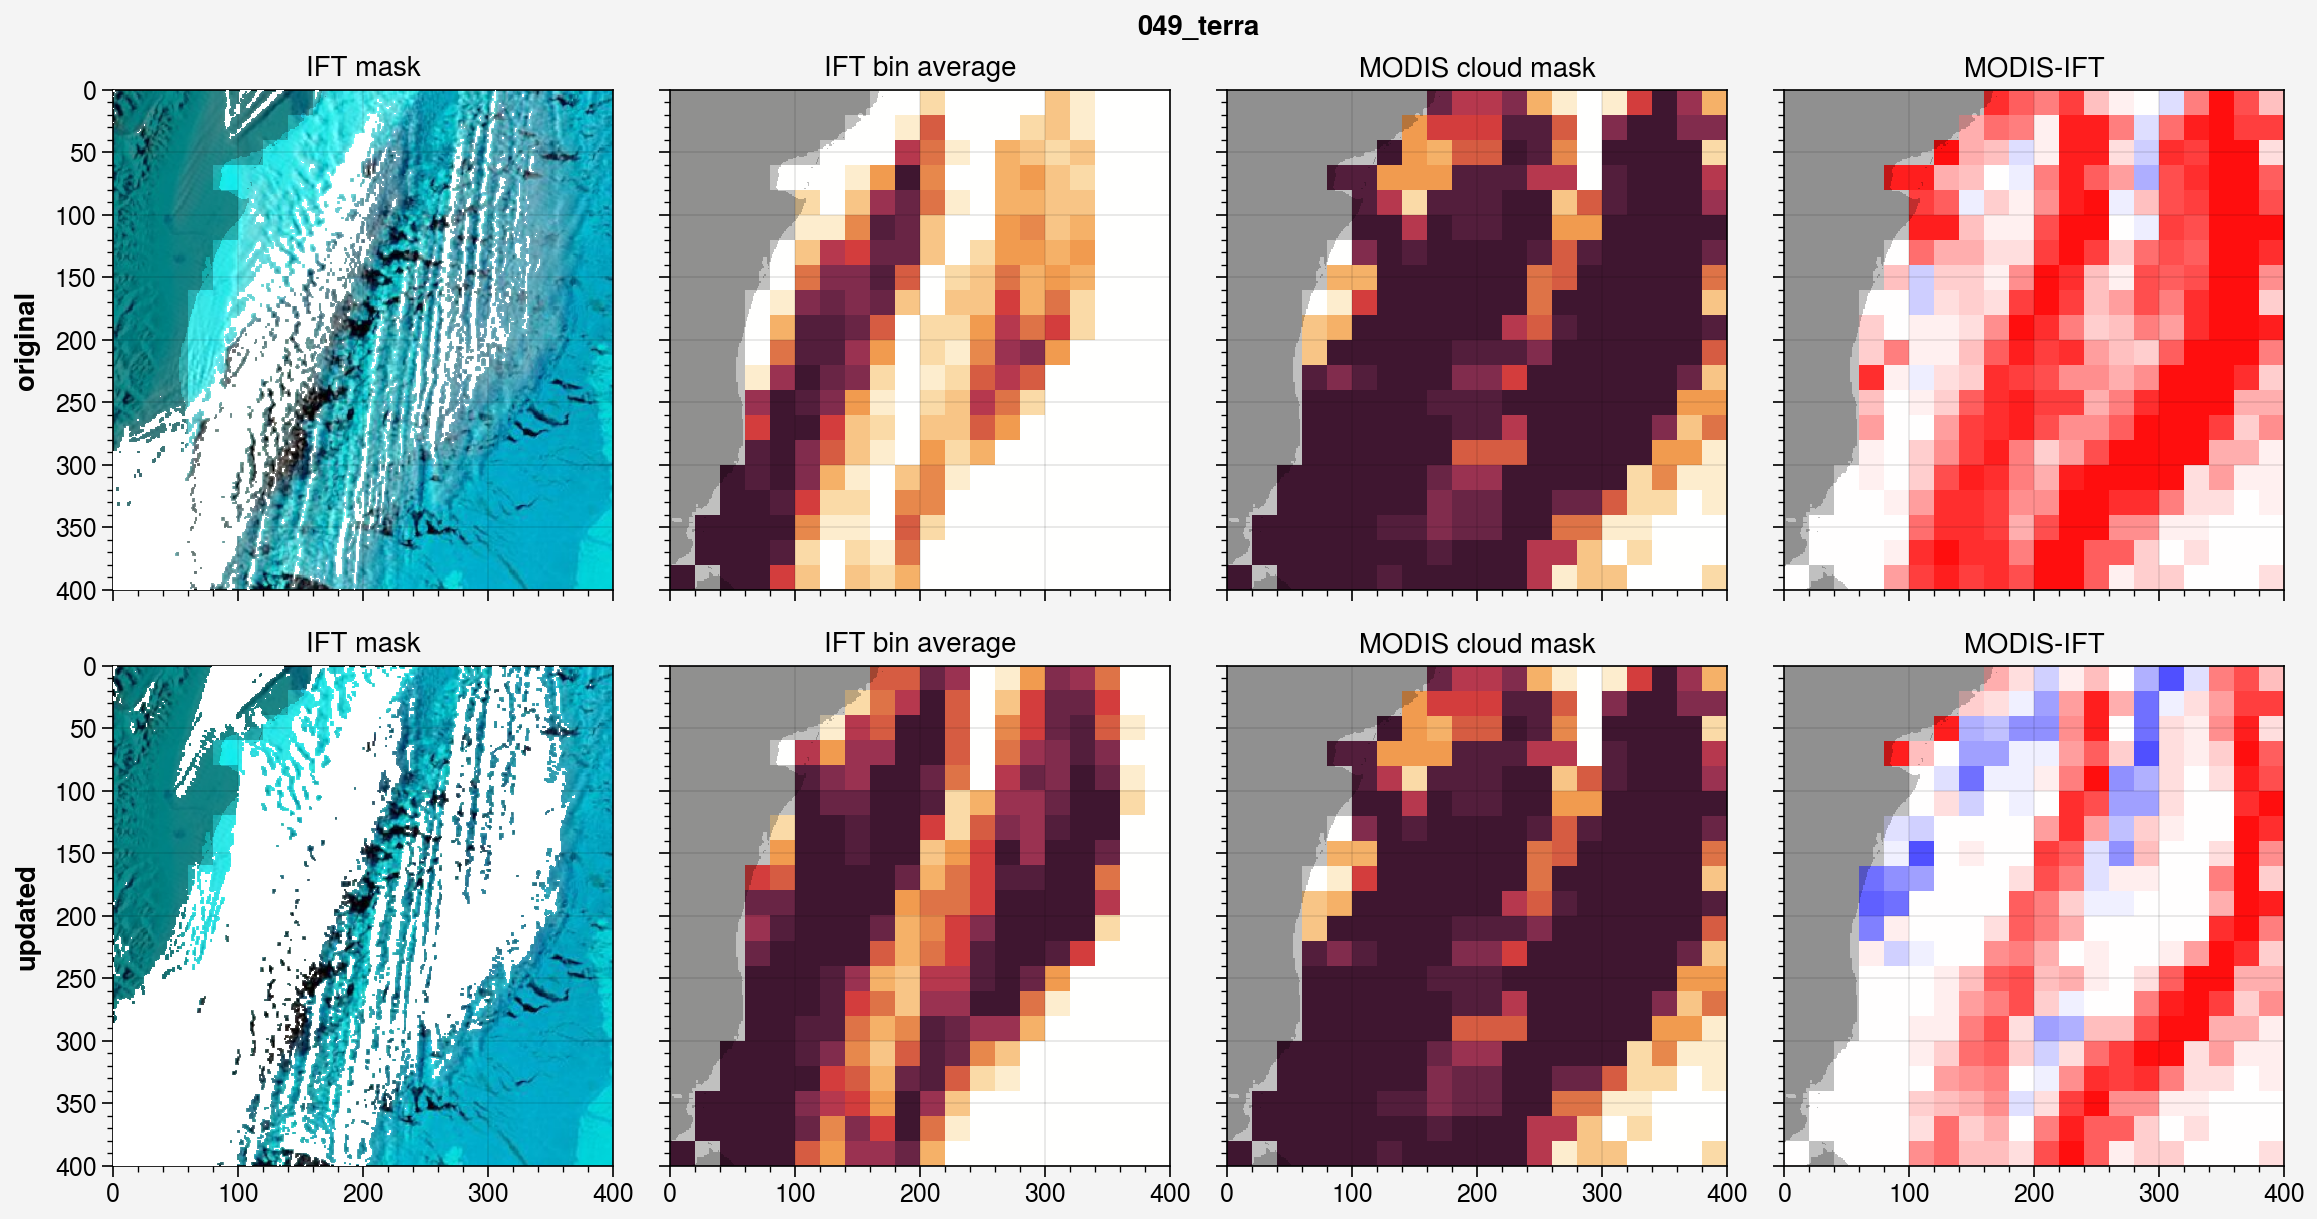

In [185]:
fig, axs = pplt.subplots(ncols=4, nrows=2)
axs.format(leftlabels=['original', 'updated'])

# assumes A is square! and that 20 evenly divides the shape
case = '049_terra'
tc = 110
original, _ = generate_masks(fc_images[case], t0=110, t7=200, t2=190, r_upper=0.75)
updated, _ = generate_masks(fc_images[case], t0=53, t7=130, t2=169, r_upper=0.53)

for ax, ift_est in zip([axs[0,:], axs[1,:]], [original, updated]):

    land = lm_images[case].squeeze() > 0
    A = ift_est.astype(int)
    n = A.shape[0]
    m = int(n/20)
    # reshapes to dimension (80, 20, 80, 20)
    Lmean = land.astype(int).reshape([m, n//m, m, n//m]).mean(3).mean(1)
    Amean = A.reshape([m, n//m, m, n//m]).mean(3).mean(1)
    Amean = np.ma.masked_array(Amean, mask=Lmean > 0.5)
    bin_edges = np.linspace(0, 100, 17)
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    
    ift_vec = np.ravel(Amean*100)
    ift_dig = np.digitize(ift_vec, bin_edges) - 1 # Digitize puts 0 if less than the lowest bin, so you have to subtract.
    ift_dig[ift_dig == 16] = 15 # Put values of exactly 100 into the highest bin
    binned_ift = np.reshape(bin_centers[ift_dig], Amean.shape)
    CF = np.ma.masked_array(cf_images[case].values[::20, ::20], mask=Lmean > 0.5)
    
    
    
    ax[0].imshow(reshape_as_image(fc_images[case]), extent=[0, 400, 400, 0])
    ax[0].imshow(np.ma.masked_array(A, A==0), c='w', extent=[0, 400, 400, 0], zorder=10)
    ax[1].imshow(binned_ift, extent=[0, 400, 400, 0])
    ax[2].imshow(CF, extent=[0, 400, 400, 0])
    ax[3].imshow(CF - binned_ift, vmin=-100, vmax=100, cmap='bwr',
                extent=[0, 400, 400, 0])
    for ax0 in ax:
        ax0.imshow(np.ma.masked_array(land.astype(int), land==0), color='k', alpha=0.25, extent=[0, 400, 400, 0])
        ax0.imshow(np.ma.masked_array(Lmean, Lmean < 0.5), color='k', alpha=0.25, extent=[0, 400, 400, 0])
    ax[0].format(title='IFT mask'.format(tc=tc))
    ax[1].format(title='IFT bin average')
    ax[2].format(title='MODIS cloud mask')
    ax[3].format(title='MODIS-IFT')
axs.format(suptitle=case)

In [171]:
generate_masks?

Signature:
generate_masks(
    fc_image,
    t0=110,
    t7=200,
    t2=190,
    r_lower=0,
    r_upper=0.75,
    variant='LSW2019',
)
Docstring:
Generate the all-cloud and opaque-cloud masks. Opaque cloud mask is defined as a subset
of the all-cloud mask where the ice floes are visible.
File:      /var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_62175/1809521259.py
Type:      function

In [126]:
def get_binned_ift_est(fc, tc_threshold):
    """Computes a 5 km average of the IFT data and bins it into the
    same resolution as the MODIS cloud fraction data."""
    ift_est = fc > tc_threshold
    
    A = ift_est.astype(int)
    n = A.shape[0]
    m = int(n/20)
    
    # reshapes to dimension (80, 20, 80, 20)
    Amean = A.reshape([m, n//m, m, n//m]).mean(3).mean(1)
    
    bin_edges = np.linspace(0, 100, 17)
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    
    ift_vec = np.ravel(Amean*100)
    ift_dig = np.digitize(ift_vec, bin_edges) - 1 # Digitize puts 0 if less than the lowest bin, so you have to subtract.
    ift_dig[ift_dig == 16] = 15 # Put values of exactly 100 into the highest bin
    binned_ift = np.reshape(bin_centers[ift_dig], Amean.shape)

    return binned_ift

def get_binned_landmask(lm, lm_threshold=0.5):
    """Bins the land mask value and returns boolean array where True if land is greater than 50%"""
    L = (lm == 0).astype(int)
    n = L.shape[0]
    m = int(n/20)
    
    # reshapes to dimension (80, 20, 80, 20)
    Lmean = L.reshape([m, n//m, m, n//m]).mean(3).mean(1)
    return Lmean > lm_threshold

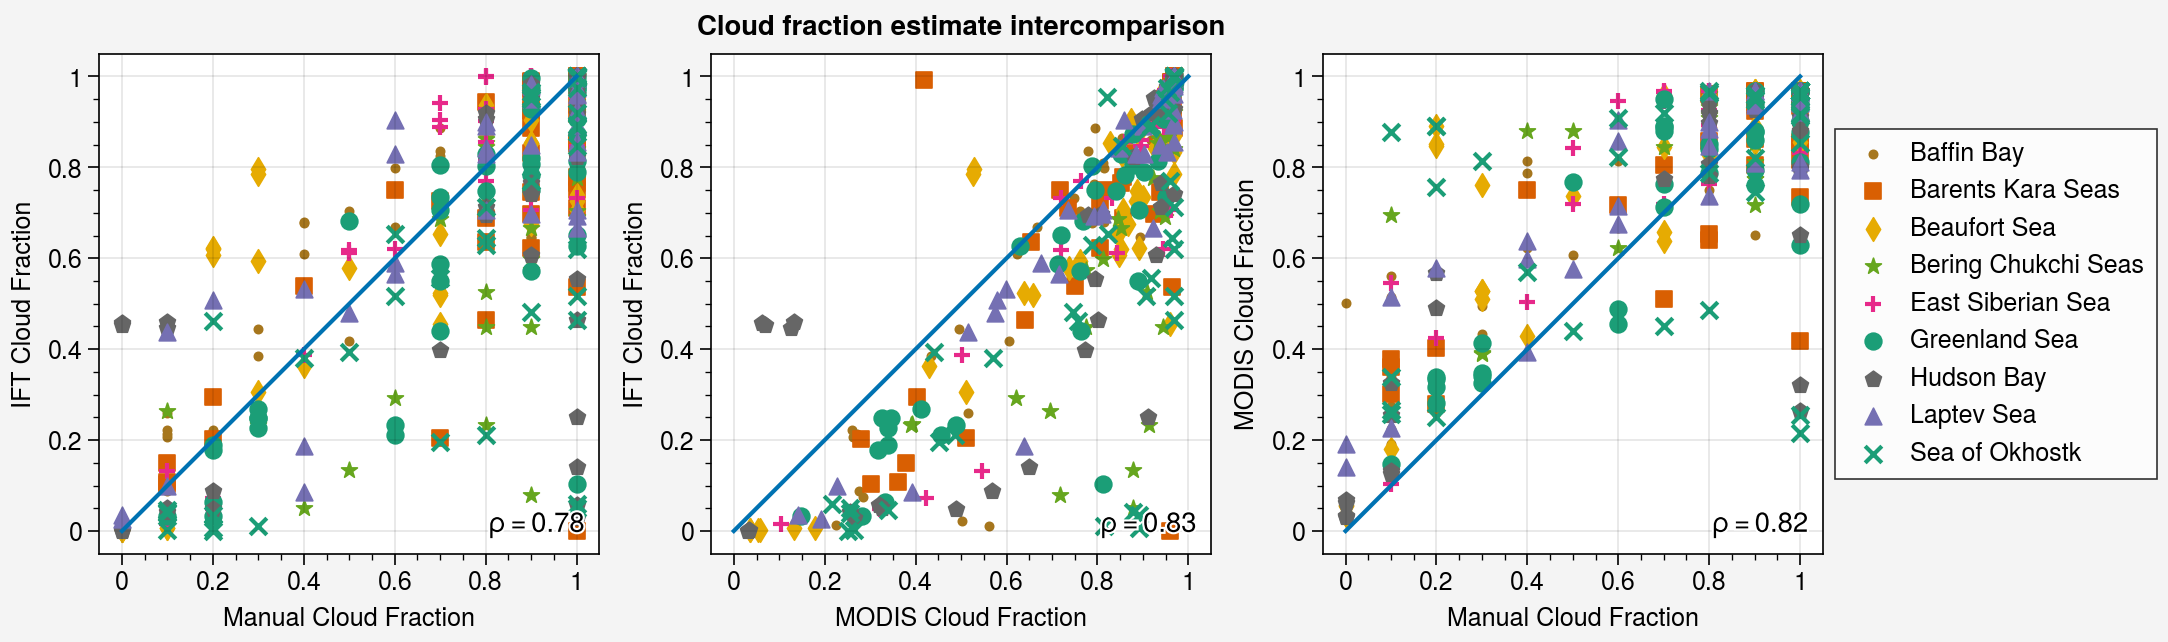

In [222]:
# Rough comparison between the estimates
# Note: the land pixels are included! The IFT cloud mask is not intended for those cases.

regions = pd.read_csv(dataloc + '/data/metadata/region_definitions.csv', index_col=0)

colors = {region: c['color'] for region, c in zip(
            regions.index,
            pplt.Cycle('dark2', len(regions)))}
markerstyles = {region: ls for region, ls in zip(regions.index,
                        ['o', 's', '^', '+', '*', 'd', '.', 'p', 'x'])}

regions['print_title'] = [c.replace('_', ' ').title().replace('Of', 'of') for c in regions.index]
regions = regions.sort_values('center_lon')

for case in fc_images:
    clouds_view, cloud_mask = generate_masks(fc_images[case], t0=53, t7=130, t2=169, r_upper=0.53)
    df.loc[case, 'ift_est'] = np.mean(clouds_view)
    
fig, axs = pplt.subplots(ncols=3, share=False)
for ax, col in zip(axs, ['cloud_fraction_manual', 'cloud_fraction_modis']):
    for region, group in df.groupby('region'):
    
        ax.scatter(group[col], group['ift_est'], label=regions.loc[region, 'print_title'],
               m=markerstyles[region], color=colors[region])
    
    ax.plot([0, 1], [0, 1])
    ax.format(ylim=(-0.05, 1.05), xlim=(-0.05, 1.05),
          ylabel='IFT Cloud Fraction')
    ax.format(lrtitle='$\\rho=$' + str(np.round(df[col].corr(df['ift_est']), 2)))

axs[0].format(xlabel='Manual Cloud Fraction')
axs[1].format(xlabel='MODIS Cloud Fraction')

for region, group in df.groupby('region'):
    axs[2].scatter(group['cloud_fraction_manual'], group['cloud_fraction_modis'], label=regions.loc[region, 'print_title'],
               m=markerstyles[region], color=colors[region])
axs[2].plot([0, 1], [0, 1])
axs[2].format(ylim=(-0.05, 1.05), xlim=(-0.05, 1.05),
          ylabel='MODIS Cloud Fraction', xlabel='Manual Cloud Fraction')
axs[2].format(lrtitle='$\\rho=$' + str(np.round(df['cloud_fraction_manual'].corr(df['cloud_fraction_modis']), 2)))

axs[2].legend(loc='r', ncols=1)    

axs.format(suptitle='Cloud fraction estimate intercomparison')

fig.save('../figures/comparison_cloud_estimates.png', dpi=300)

# Pixel unmasking: identifying optically thin clouds
The original algorithm is
1. Mask all pixels with $l_1 > 110 = T_C$.
2. Unmask pixels with $l_1 < 200 = T_1$ and $l_2 > 190 = T_2$.
3. Unmask pixels with $l_1/l_2 < 0.75 = R_{1,2}$.

In the prior sections, we have found that the first step underestimates the total cloud cover (noting, however, that this high threshold was set just to mask the clouds with the highest opacity). To identify the thin clouds, we have three parameters to adjust, making the optimization a bit more challenging. 



Parameters to optimize over
1. $T_1$. Operates on channel 1.
2. $T_2$. Operates on channel 2.
3. $R_{1,2}$. Ratio of $T_1$ and $T_2$. Pixels with $R_{1,2}$ less than the threshold are unmasked.

This all connects via drawing a piecewise linear parametrized curve dividing cloud from non-cloud pixels.

In [11]:
def generate_masks(fc_image, t1, t2, r_lower, r_upper, tc):
    """Generate the all-cloud and opaque-cloud masks. Opaque cloud mask is defined as a subset
    of the all-cloud mask where the ice floes are visible."""
    clouds_view = fc_image[0,:,:] > tc # true == cloudy pixel
    mask_b7b2 = (fc_image[0,:,:] < t1) & (fc_image[1,:,:] > t2) # true == thin cloud
    mask_ratio = fc_image[0,:,:]/fc_image[1,:,:]
    mask_cloud_ice = (mask_ratio > r_lower) & (mask_ratio < r_upper)
    mask_cloud_ice = mask_cloud_ice & mask_b7b2
    cloud_mask = ~(mask_cloud_ice | ~clouds_view)
    return clouds_view, cloud_mask

The calibration in this section aims to minimize the reduction in the cloud mask while maximizing the fraction of manually-labeled ice floes that are uncovered. A big challenge here is that the images vary quite a bit in the number of ice floes. It is not obvious how we should weight the results, whether by pixels or what.

# Selecting reference regions for pixel thresholds
1. Using MASIE ice and land to find open water

TBD: 
* Assign test / train cases
* Check images with full cloud cover - any where the manual estimate especially disagrees? What threshold to use on cloud fraction for mask comparison?
* Identify cases where the cloud mask gets confused by the ice edge
* How to aggegrate? Do I fit a distribution?
* How should I report the cases where the mask should not have been removed?
* Should the B7/B2 ratio actually have a shift (e.g. (B7 + x)/(B2 + y) < ratio? Where should the line be drawn?
* All of this is really just using a piecewise linear threshold function.

In [192]:
# cloudy cases
# Cases that are 90% cloudy, part of our training data, and 
cloud_data = pixel_data['cloudy'].loc[pixel_data['cloudy'].training].groupby('case').filter(lambda x: len(x) > 0.9*400**2)
cloudy_cases_test = list(np.random.choice(cloud_data.case.unique(), 12, replace=False))

cloudy_ice_data = pixel_data['cloudy_ice'].loc[pixel_data['cloudy_ice'].training].groupby('case').filter(lambda x: len(x) > 50**2)
cloudy_ice_data = cloudy_ice_data.loc[[x for x in cloudy_ice_data.index if cloudy_ice_data.loc[x, 'case'] not in cloudy_cases_test]]
cloudy_ice_cases_test = list(np.random.choice(cloudy_ice_data.case.unique(), 12, replace=False))

clearsky_ice_data = pixel_data['clearsky_ice'].loc[pixel_data['clearsky_ice'].training].groupby('case').filter(lambda x: len(x) > 100**2)
clearsky_ice_data = clearsky_ice_data.loc[[x for x in clearsky_ice_data.index if clearsky_ice_data.loc[x, 'case'] not in cloudy_ice_cases_test]]
clearsky_ice_cases_test = list(np.random.choice(clearsky_ice_data.case.unique(), 12, replace=False))

# Visualization to examine cases
- 12 cases randomly selected from each division
- Overlay the pixels selected for the training data for each case
- Also look at which pixels get masked by the original cloud mask

In [195]:
#### Plot images with no overlays #####
for title, cases in zip(['cloudy', 'cloudy_ice', 'clearsky_ice'], [cloudy_cases_test, cloudy_ice_cases_test, clearsky_ice_cases_test]):
    fig, axs = pplt.subplots(nrows=3, ncols=4)
    for ax, case in zip(axs, cases):
        ax.imshow(reshape_as_image(fc_images[case]))
        ax.format(title=case)
    ax.format(suptitle='{t} Case Examples'.format(t=title.replace('_', ' ').title()))
    fig.save('../figures/example_{t}_cases.png'.format(t=title), dpi=300)
    pplt.close(fig)

In [210]:
#### Overlay masks, IFT original mask
for title, cases in zip(['cloudy', 'cloudy_ice', 'clearsky_ice'], [cloudy_cases_test, cloudy_ice_cases_test, clearsky_ice_cases_test]):
    fig, axs = pplt.subplots(nrows=3, ncols=4)
    for ax, case in zip(axs, cases):
        
        ax.imshow(reshape_as_image(fc_images[case]), zorder=0)
        
        land = np.sum(lm_images[case], axis=0) > 1 # replace with boolean mask in the end
        ax.imshow(np.ma.masked_array(land.astype(int), land==0), color='k', zorder=1)

        if case in lb_images:
            ice_floes = lb_images[case][0,:,:] > 0
            fast_ice = lf_images[case][0,:,:] > 0
            ice_pixels = ice_floes | fast_ice
            ax.imshow(np.ma.masked_array(ice_pixels, mask=~ice_pixels), c='gray0', zorder=3)

        modis_mask = cf_images[case] > 20
        ax.imshow(np.ma.masked_array(modis_mask.astype(int), mask=~modis_mask), vmin=0, vmax=1, c='gold', alpha=0.5, zorder=4)
        
        clouds_view, cloud_mask = generate_masks(fc_images[case])
        ax.imshow(np.ma.masked_array(clouds_view.astype(int), mask=~clouds_view), vmin=0, vmax=1, c='r', alpha=0.5, zorder=5)
  
        ax.format(title=case)

        h = [ax.plot([],[], m='s', lw=0, color='gold'),
        ax.plot([],[], m='s', lw=0, color='r'),
        ax.plot([],[], m='s', lw=0, color='gray0')
        ]
        ax.legend(h, ['MODIS Cloud', 'IFT Cloud', 'Ice'], ncol=1, alpha=1)
        
    ax.format(suptitle='{t} Case Examples (Original IFT Cloud Mask)'.format(t=title.replace('_', ' ').title()))
    fig.save('../figures/example_ift_orig_{t}_cases.png'.format(t=title), dpi=300)
    pplt.close(fig)


In [211]:
#### Overlay masks, IFT original mask
for title, cases in zip(['cloudy', 'cloudy_ice', 'clearsky_ice'], [cloudy_cases_test, cloudy_ice_cases_test, clearsky_ice_cases_test]):
    fig, axs = pplt.subplots(nrows=3, ncols=4)
    for ax, case in zip(axs, cases):
        
        ax.imshow(reshape_as_image(fc_images[case]), zorder=0)
        
        land = np.sum(lm_images[case], axis=0) > 1 # replace with boolean mask in the end
        ax.imshow(np.ma.masked_array(land.astype(int), land==0), color='k', zorder=1)

        if case in lb_images:
            ice_floes = lb_images[case][0,:,:] > 0
            fast_ice = lf_images[case][0,:,:] > 0
            ice_pixels = ice_floes | fast_ice
            ax.imshow(np.ma.masked_array(ice_pixels, mask=~ice_pixels), c='gray0', zorder=3)

        modis_mask = cf_images[case] > 20
        ax.imshow(np.ma.masked_array(modis_mask.astype(int), mask=~modis_mask), vmin=0, vmax=1, c='gold', alpha=0.5, zorder=4)
        
        clouds_view, cloud_mask = generate_masks(fc_images[case], t0=53, t7=130, t2=169, r_upper=0.53)
        ax.imshow(np.ma.masked_array(clouds_view.astype(int), mask=~clouds_view), vmin=0, vmax=1, c='r', alpha=0.5, zorder=5)
  
        ax.format(title=case)

        h = [ax.plot([],[], m='s', lw=0, color='gold'),
        ax.plot([],[], m='s', lw=0, color='r'),
        ax.plot([],[], m='s', lw=0, color='gray0')
        ]
        ax.legend(h, ['MODIS Cloud', 'IFT Cloud', 'Ice'], ncol=1, alpha=1)
        
    ax.format(suptitle='{t} Case Examples (Updated IFT Cloud Mask)'.format(t=title.replace('_', ' ').title()))
    fig.save('../figures/example_ift_updated_{t}_cases.png'.format(t=title), dpi=300)
    pplt.close(fig)



## Pool the pixel-wise data

The pixel data now includes extra bandwidths, and each subset is a dataframe with the case information that we can filter based on whether it is training data or not.

In [103]:
for category in pixel_data:
    pixel_data[category]['b7/b2'] = pixel_data[category]['b7'] / (pixel_data[category]['b2'] + 1)
    pixel_data[category]['ndsi'] = (pixel_data[category]['b2'] - pixel_data[category]['b7'])/(pixel_data[category]['b2'] + pixel_data[category]['b7'] + 1)

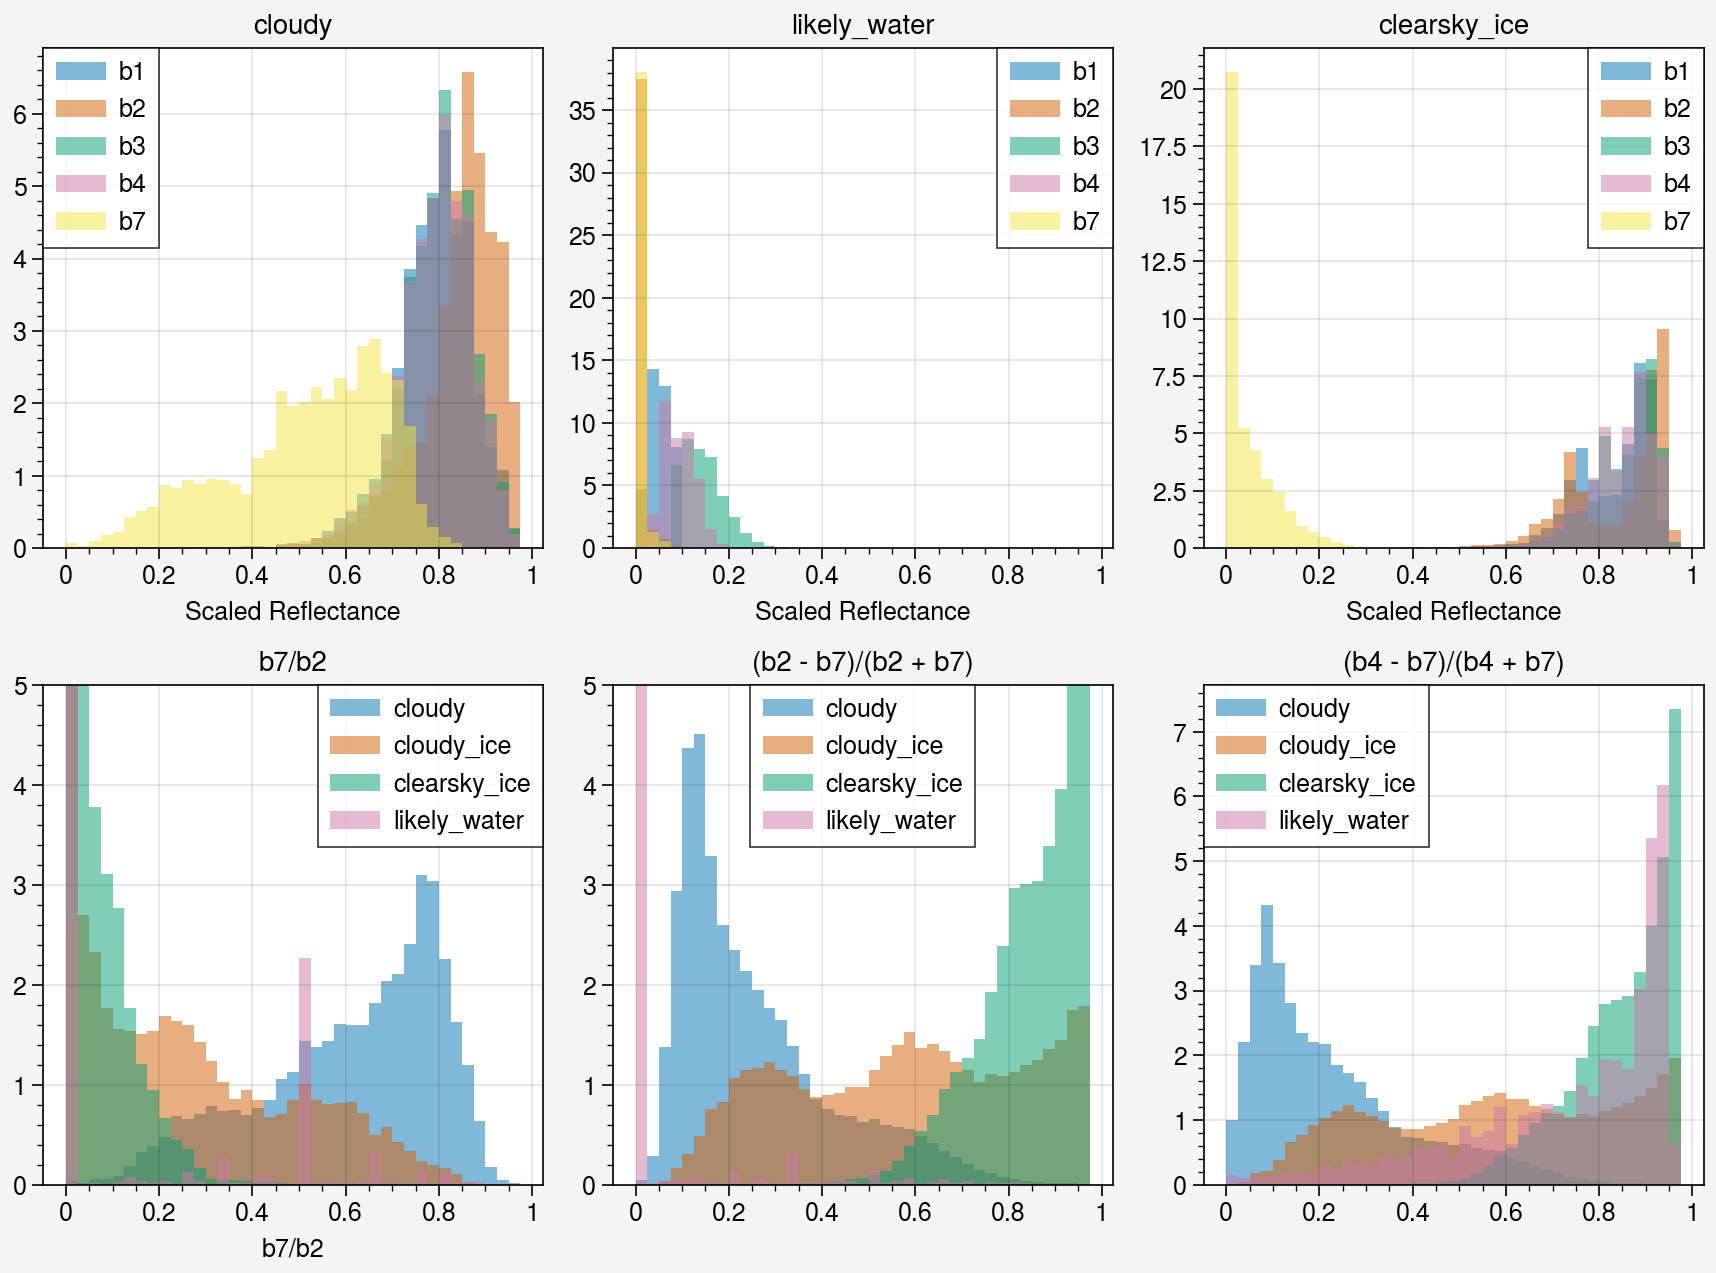

In [104]:
bins = np.arange(0, 1, 0.025)
fig, axs = pplt.subplots(ncols=3, nrows=2, share=False)
for ax, category in zip(axs[0,:], ['cloudy', 'likely_water', 'clearsky_ice']):
    px_df = pixel_data[category]
    idx = px_df.training
    for band in ['b1', 'b2', 'b3', 'b4', 'b7']:
        data_x = px_df.loc[idx, band]/255.0
        valid_idx = data_x.sample(10000).index
        ax.hist(data_x[valid_idx], alpha=0.5, density=True, bins=bins, label=band)
    
    ax.format(title=category, xlabel='Scaled Reflectance')
    ax.legend(ncols=1)

# Same data, but plotting the different types rather than different measures within each panel
bins = np.arange(0, 1, 0.025)
ax = axs[1,0]
for category in ['cloudy', 'cloudy_ice', 'clearsky_ice', 'likely_water']:
    px_df = pixel_data[category]
    idx = px_df.training    
    data_x = px_df.loc[idx, 'b7/b2']
    valid_idx = data_x.sample(10000).index
    ax.hist(data_x[valid_idx], alpha=0.5, density=True, bins=bins, label=category)
    ax.format(title='b7/b2', ylim=(0, 5))
    ax.legend(ncols=1)    
    
ax = axs[1,1]
for category in ['cloudy', 'cloudy_ice', 'clearsky_ice', 'likely_water']:
    px_df = pixel_data[category]
    idx = px_df.training    
    data_x = (px_df.loc[idx, 'b2'] - px_df.loc[idx, 'b7'])/(px_df.loc[idx, 'b7'] + px_df.loc[idx, 'b2'])
    data_x[np.isnan(data_x)] = 0
    valid_idx = ~np.isnan(data_x)
    ax.hist(data_x[valid_idx], alpha=0.5, density=True, bins=bins, label=category)
    ax.format(title='(b2 - b7)/(b2 + b7)', ylim=(0, 5))
    ax.legend(ncols=1) 
    
ax = axs[1,2]
for category in  ['cloudy', 'cloudy_ice', 'clearsky_ice', 'likely_water']:
    px_df = pixel_data[category]
    idx = px_df.training    
    data_x = (px_df.loc[idx, 'b4'] - px_df.loc[idx, 'b7'])/(px_df.loc[idx, 'b7'] + px_df.loc[idx, 'b4'])
    valid_idx = ~np.isnan(data_x)
    ax.hist(data_x[valid_idx], alpha=0.5, density=True, bins=bins, label=category)
    ax.format(title='(b4 - b7)/(b4 + b7)')
    ax.legend(ncols=1)    

The NDSII has been used to identify snow and ice from satellite imagery in numerous studies. For the regions in our study, we find that NDSII does have some discriminatory power, but that cloudy pixels do overlap with the cloudy_ice pixels. Water and ice are strongly separated for the most part. b7 and b2 often are 0 for water pixels, so both b7/b2 ratio and NDSII are undefined in those cases. Band 4 (Green) is sometimes used for NDSI calculations but here would be a poor separator between the two distributions.


TBD: 
* Check "water pixels" in threshold maps. How much correction is needed?
* Calculate fraction of cloud-ice pixels that overlap with cloudy pixels.
* 

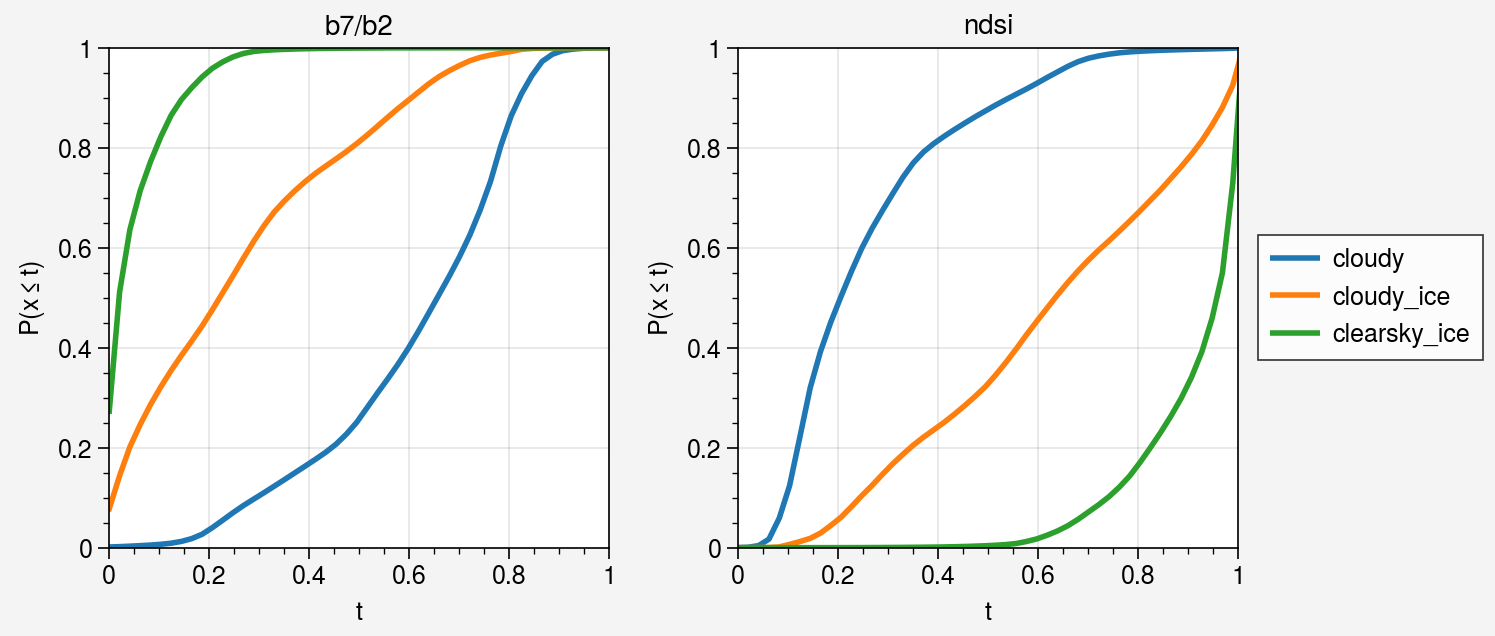

In [114]:
from scipy.interpolate import interp1d

fig, axs = pplt.subplots(ncols=2, share=False)
for ax, meas in zip(axs, ['b7/b2', 'ndsi']):
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'gray']
    for color, category in zip(colors, ['cloudy', 'cloudy_ice', 'clearsky_ice']):
        fraction_below = []
        
        tlist = np.linspace(0, 1.01, 50)
        for t in tlist:
            # could re-calculate to use fraction where b7 <= b2 * t
            fraction_below.append(np.mean(pixel_data[category][meas] <= t))

        ax.plot(tlist, fraction_below, label=category, color=color, lw=2)
    
        ax.format(title=meas, xlim=(0, 1), ylim=(0, 1))
        ax.format(ylabel='$P(x \\leq t)$', xlabel='t')
ax.legend(ncol=1, loc='r')


In [110]:
print('Likely water pixels where band 2 is identically 0')
np.sum(pixel_data['likely_water']['b2'] == 0) / len(pixel_data['likely_water'])

Likely water pixels where band 2 is identically 0


0.7683134167619948

In [111]:
print('Likely water pixels where band 7 is identically 0')
np.sum(pixel_data['likely_water']['b7'] == 0) / len(pixel_data['likely_water'])

Likely water pixels where band 7 is identically 0


0.8020052923640343

In [112]:
print('Likely water pixels where both band 2 and band 7 are identically 0')
np.sum((pixel_data['likely_water']['b7'] == 0) & (pixel_data['likely_water']['b2'] == 0)) / len(pixel_data['likely_water'])

Likely water pixels where both band 2 and band 7 are identically 0


0.6876723647041747

# Interpretation of the CDFs
These functions compute the fraction of data that are below a specific threshold. I've drawn vertical lines corresponding to where the CDF reaches specific probabilities. For example, for the cloudy pixels, we see that with a b7/b2 threshold of 0.3, essentially 100% of the clearsky pixels are to the left, and 90% of the cloudy pixels are to the right. About 40% of the cloud-covered ice pixels would be tagged as clouds in that method. It is clear that the cloudy ice pixels contain a blend of the distributions for clear and cloudy skies. 

We can answer some hypothetical questions here:
- If we want to include (A) all sea ice pixels and (B) at least X% of the cloudy ice pixels, how much cloud do we allow to be uncovered?
- If we want to cover Y% of the cloud, how much of the sea ice pixels are covered? Cloudy ice pixels?




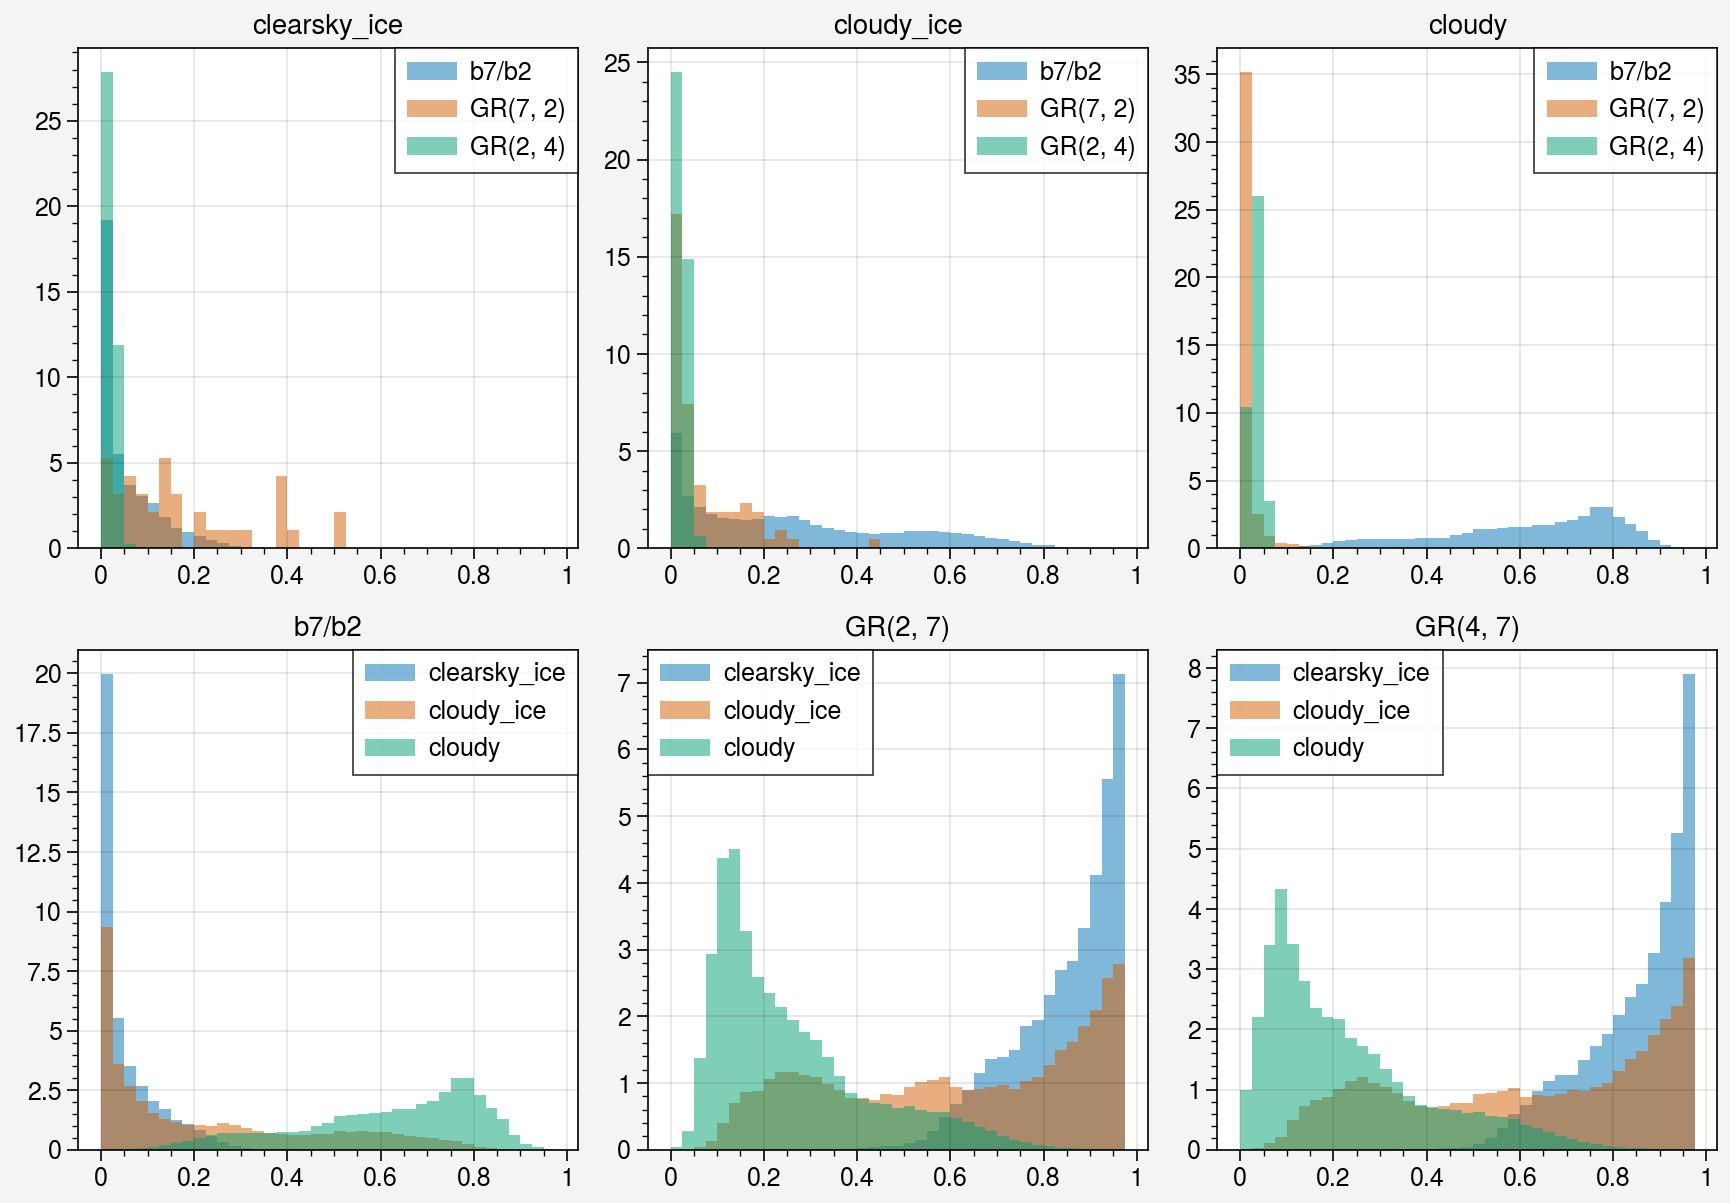

In [17]:
bins = np.arange(0, 1, 0.025)
fig, axs = pplt.subplots(ncols=3, nrows=2, share=False)
for ax, category in zip(axs[0,:], pixel_data):
    px_df = pixel_data[category]
    idx = px_df.training
    data_x = px_df.loc[idx, 'b7']/px_df.loc[idx, 'b2']
    data_y = (px_df.loc[idx, 'b7'] - px_df.loc[idx, 'b2'])/(px_df.loc[idx, 'b7'] + px_df.loc[idx, 'b2'])
    data_z = (px_df.loc[idx, 'b2'] - px_df.loc[idx, 'b4'])/(px_df.loc[idx, 'b2'] + px_df.loc[idx, 'b4'])
    valid_idx = (data_x < 1000) & (data_y < 1000)
    ax.hist(data_x[valid_idx], alpha=0.5, density=True, bins=bins, label='b7/b2')
    ax.hist(data_y[valid_idx], alpha=0.5, density=True, bins=bins, label='GR(7, 2)')
    ax.hist(data_z[valid_idx], alpha=0.5, density=True, bins=bins, label='GR(2, 4)')
    ax.format(title=category)
    ax.legend(ncols=1)

# Same data, but plotting the different types rather than different measures within each panel
bins = np.arange(0, 1, 0.025)
ax = axs[1,0]
for category in pixel_data:
    px_df = pixel_data[category]
    idx = px_df.training    
    data_x = px_df.loc[idx, 'b7']/px_df.loc[idx, 'b2']
    valid_idx = (data_x < 2) & (data_y < 2)
    ax.hist(data_x[valid_idx], alpha=0.5, density=True, bins=bins, label=category)
    ax.format(title='b7/b2')
    ax.legend(ncols=1)    
    
ax = axs[1,1]
for category in pixel_data:
    px_df = pixel_data[category]
    idx = px_df.training    
    data_x = (px_df.loc[idx, 'b2'] - px_df.loc[idx, 'b7'])/(px_df.loc[idx, 'b7'] + px_df.loc[idx, 'b2'])
    valid_idx = (data_x < 4) & (data_y < 4)
    ax.hist(data_x[valid_idx], alpha=0.5, density=True, bins=bins, label=category)
    ax.format(title='(b2 - b7)/(b2 + b7)')
    ax.legend(ncols=1) 
    
ax = axs[1,2]
for category in pixel_data:
    px_df = pixel_data[category]
    idx = px_df.training    
    data_x = (px_df.loc[idx, 'b4'] - px_df.loc[idx, 'b7'])/(px_df.loc[idx, 'b7'] + px_df.loc[idx, 'b4'])
    valid_idx = (data_x < 4) & (data_y < 4)
    ax.hist(data_x[valid_idx], alpha=0.5, density=True, bins=bins, label=category)
    ax.format(title='(b4 - b7)/(b4 + b7)')
    ax.legend(ncols=1)    

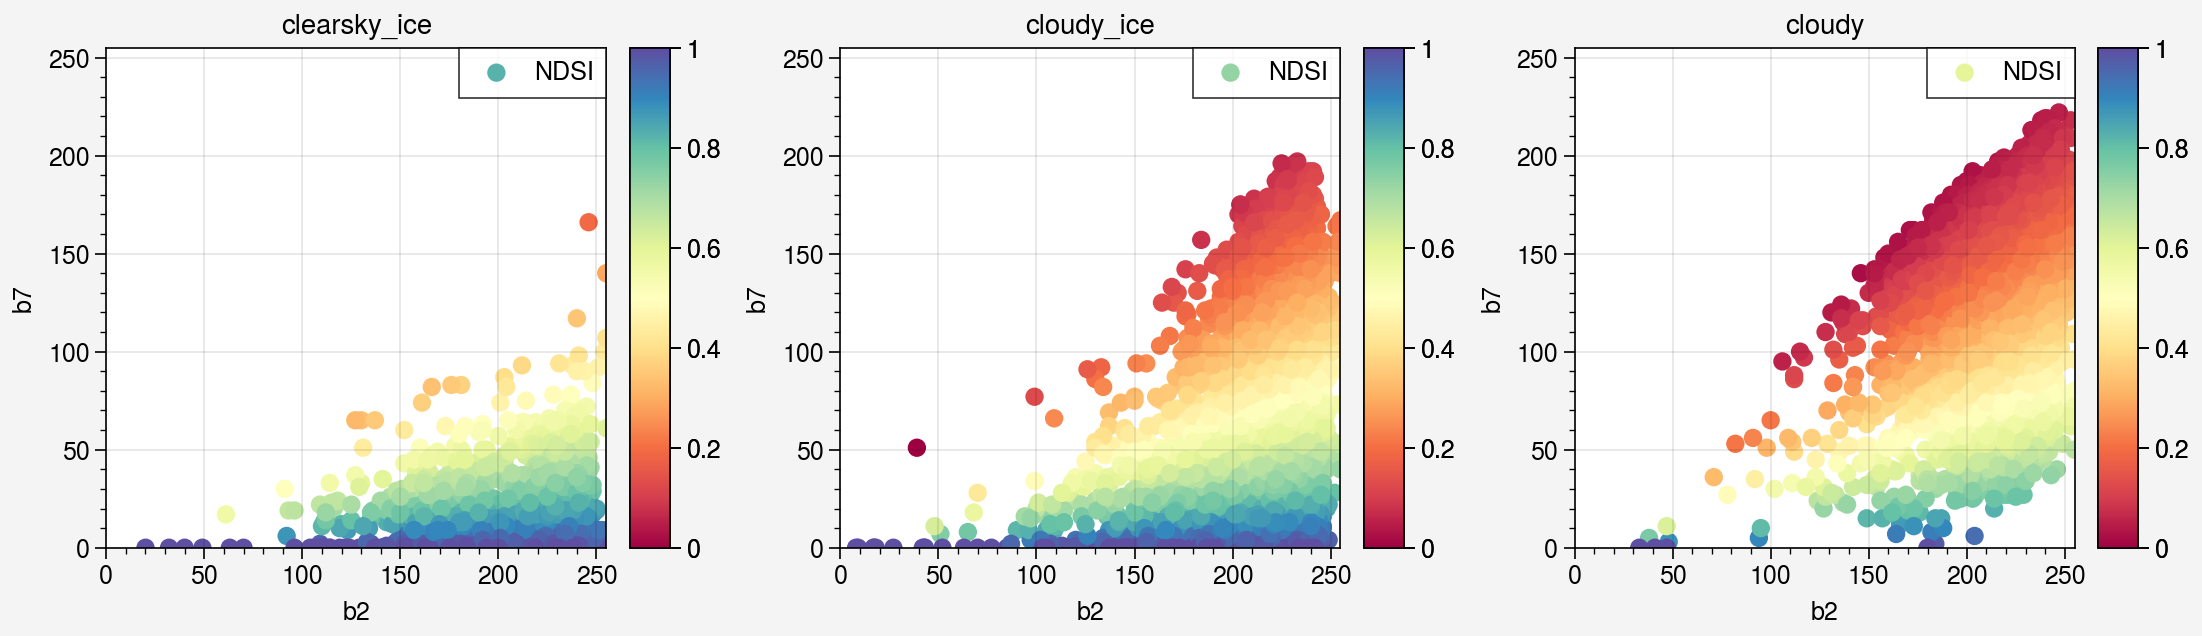

In [31]:
# f  = lambda x: -2/0.75*(x - 0.8)

fig, axs = pplt.subplots(ncols=3, share=False)
for ax, category in zip(axs, pixel_data):
    px_df = pixel_data[category]
    idx = px_df.training
    data_x = px_df.loc[idx, 'b2']
    data_y = px_df.loc[idx, 'b7']
    data_z = (px_df.loc[idx, 'b2'] - px_df.loc[idx, 'b7'])/(px_df.loc[idx, 'b2'] + px_df.loc[idx, 'b7'])
    # valid_idx = (data_x < 4) & (data_y < 4)
    valid_idx = data_x.sample(5000).index

    ax.scatter(data_x[valid_idx], data_y[valid_idx], c=data_z[valid_idx],
               cmap='spectral', colorbar='r', label='NDSI', vmin=0, vmax=1)
    # ax.plot([0, 0.8], [f(0), f(0.8)])
    ax.format(title=category, ylim=(0, 255), xlabel='b2', ylabel='b7', xlim=(0, 255))
    ax.legend(ncols=1)

In [ ]:
# f  = lambda x: -2/0.75*(x - 0.8)

fig, axs = pplt.subplots(ncols=3, share=False)
for ax, category in zip(axs, pixel_data):
    px_df = pixel_data[category]
    idx = px_df.training
    data_x = px_df.loc[idx, 'b7']/px_df.loc[idx, 'b2']
    data_y = (px_df.loc[idx, 'b4'] - px_df.loc[idx, 'b7'])/(px_df.loc[idx, 'b4'] + px_df.loc[idx, 'b7'])
    data_z = (px_df.loc[idx, 'b2'] - px_df.loc[idx, 'b7'])/(px_df.loc[idx, 'b2'] + px_df.loc[idx, 'b7'])
    valid_idx = (data_x < 4) & (data_y < 4)
    valid_idx = data_x[valid_idx].sample(1000).index
    ax.scatter(data_x[valid_idx], data_y[valid_idx], label='GR(4,7)')
    ax.scatter(data_x[valid_idx],data_z[valid_idx], label='GR(2, 7)')
    # ax.plot([0, 0.8], [f(0), f(0.8)])
    ax.format(title=category, ylim=(0, 2), xlabel='b7/b2', xlim=(0, 1))
    ax.legend(ncols=1)

The Normalized Difference Snow Index (NDSI) is frequently used for identifying snow and ice pixels in optical satellite data. It consists of the difference between reflectance in a visible channel ($R_1$) and an infrared channel ($R_2$):
$$NDSI = \frac{R_1 - R_2}{R_1 + R_2}$$

In [ ]:
fig, ax = pplt.subplots()
bins = np.linspace(0, 256, 33)
binc = 0.5*(bins[1:] + bins[:-1])


for category, color in zip(['clearsky_ice', 'cloudy_ice'], ['k', 'r']):

    px_df = pixel_data[category]
    idx = px_df.training
    data_x = (px_df.loc[idx, 'b7'] - px_df.loc[idx, 'b2'])/(px_df.loc[idx, 'b7'] + px_df.loc[idx, 'b2'])/
    data_y = (px_df.loc[idx, 'b2'] - px_df.loc[idx, 'b4'])/(px_df.loc[idx, 'b2'] + px_df.loc[idx, 'b4'])/

    H, _, _ = np.histogram2d(data_x, data_y, bins=[bins, bins])
    H = H.T
    ax.contour(binc, binc, np.log(np.ma.masked_array(H, H == 0)),
              vmin=np.log(5), vmax=10, levels=5, lw=2,
              c=color)


px_df = pixel_data['cloudy']
idx = px_df.training
data_x = (px_df.loc[idx, 'b7'] - px_df.loc[idx, 'b2'])/(px_df.loc[idx, 'b7'] + px_df.loc[idx, 'b2'])/
data_y = (px_df.loc[idx, 'b2'] - px_df.loc[idx, 'b4'])/(px_df.loc[idx, 'b2'] + px_df.loc[idx, 'b4'])/

H, _, _ = np.histogram2d(data_x, data_y, bins=[bins, bins])
H = H.T
ax.contourf(binc, binc, np.log(np.ma.masked_array(H, H == 0)),
              vmin=np.log(5), vmax=10, levels=5, lw=1,
              cmap='blues', extend='both', alpha=0.5)

h = [ax.plot([],[],ls='-', c='k', lw=2),
     ax.plot([],[],ls='-', c='r', lw=2),
     ax.plot([],[],ls='-', c='steelblue', lw=10)]
ax.legend(h, ['Clear-sky ice', 'Cloud-obscured ice', 'Cloud'], ncols=1, loc='lr')
ax.format(ylabel='Band 4', xlabel='Band 2', title='Joint distribution B2, B4')
fig.save('../figures/joint_dist_b2_b4.png', dpi=300)

In [13]:
def cloud_mask(b2, b7, t0=110, t_b7=200, t_b2=190, t_b7b2=0.75):
    step_1 = b7 > t0
    step_2 = b7 < b2*t_b7b2
    step_3 = (b7 < t_b7) & (b2 > t_b2)
    return step_1 & ~(step_2 | step_3)

In [16]:
# Make dataframes
clear_ice = pd.DataFrame({'case': case_ice_nocloud, 'b7': b7_ice_nocloud, 'b2': b2_ice_nocloud, 'training': df.loc[case_ice_nocloud, 'training'].values})
cloudy_ice = pd.DataFrame({'case': case_ice_cloud, 'b7': b7_ice_cloud, 'b2': b2_ice_cloud, 'training': df.loc[case_ice_cloud, 'training'].values})
cloudy = pd.DataFrame({'case': case_cloud, 'b7': b7_cloud, 'b2': b2_cloud, 'training': df.loc[case_cloud, 'training'].values})

In [17]:
print('Number of pixels (thousands)')
for title, data in zip(['B7 Clearsky Ice', 'B2 Clearsky Ice', 'B7 Cloudy Ice', 'B2 Cloudy Ice', 'B7 Cloud', 'B2 Cloud'],
                       [clear_ice['b7'], clear_ice['b2'], cloudy_ice['b7'], cloudy_ice['b2'], cloudy['b7'], cloudy['b2']]):
    print(title, int(np.round(len(data)/1e3, 0)))

Number of pixels (thousands)
B7 Clearsky Ice 897
B2 Clearsky Ice 897
B7 Cloudy Ice 655
B2 Cloudy Ice 655
B7 Cloud 11904
B2 Cloud 11904


In [336]:
def get_thresholds(b2_threshold, b2_data, b7_data, method='quantile'):
    """Starting from a proposed b2 threshold, estimate thresholds for b7
    and for the b7/b2 ratio based on the distribution of b2_data and b7_data."""

    b7_idx = (b2_data > b2_threshold) & (b7_data > 5)
    r_idx = ((b2_data > 0) & (b2_data <= b2_threshold)) & (b7_data > 5)
    if method == 'quantile':    
        r = b7_data[r_idx] / b2_data[r_idx]
        b7b2_threshold = np.round(np.quantile(r, 0.99), 2)
        b7_threshold = np.quantile(b7_data[b7_idx], 0.99)
        if b7_threshold < b2_threshold * b7b2_threshold:
            b7_threshold = b2_threshold * b7b2_threshold
        
        return (b7_threshold, b7b2_threshold)
        
    elif method == 'iqr_outlier':
        b7_median = np.median(b7_data[b7_idx])
        b7_iqr = np.diff(np.quantile(b7_data[b7_idx], [0.25, 0.75])).squeeze()
        b7_threshold = b7_median + 1.5*b7_iqr

        # b7_subset = b7_data[b2_data <= b2_threshold]
        # b2_subset = b2_data[b2_data <= b2_threshold]
        r = b7_data[r_idx] / b2_data[r_idx]
        # r = r[(r > 0) & (r < 1e3)]
        r_median = np.median(r)
        r_iqr = np.diff(np.quantile(r, [0.25, 0.75])).squeeze()
        b7b2_threshold = np.round(r_median + 1.5*r_iqr, 2)
        return b7_threshold, b7b2_threshold
        
def compute_error(tau_init, tau_b2, tau_b7, tau_b7b2, b2_data, b7_data):
    """Computes the fraction of cloud-covered ice pixels labeled as clear"""
    idx = b7_data >= tau_init
    idx = idx & ~((tau_b2 < b2_data) & (tau_b7 > b7_data))
    idx = idx & (b7_data / b2_data > tau_b7b2)
    return(1-np.sum(idx)/len(idx))

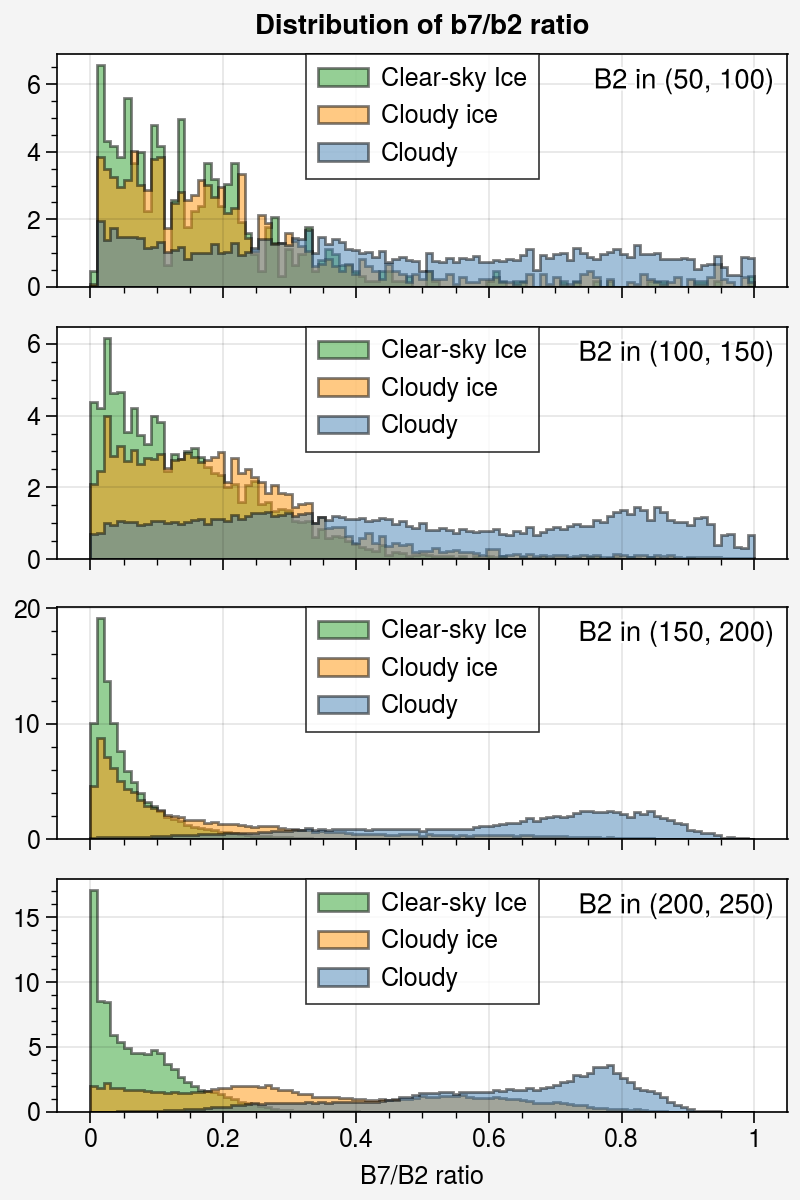

In [19]:
fig, axs = pplt.subplots(width=4, height=6, nrows=4)
b2_data = b2_ice_cloud
b7_data = b7_ice_cloud
for ax, bandstart in zip(axs, np.arange(50, 201, 50)):
    for b2_data, b7_data, label, color in zip([clear_ice.loc[clear_ice.training, 'b2'], cloudy_ice.loc[cloudy_ice.training, 'b2'], cloudy.loc[cloudy.training, 'b2']],
                                       [clear_ice.loc[clear_ice.training, 'b7'], cloudy_ice.loc[cloudy_ice.training, 'b7'], cloudy.loc[cloudy.training, 'b7']],
                                       ['Clear-sky Ice', 'Cloudy ice', 'Cloudy'],
                                       ['tab:green', 'tangerine', 'steelblue']):
        idx = (b2_data > bandstart) & (b2_data <= bandstart + 50)
        idx = idx & (b2_data > 0)
        idx = idx & (b7_data > 0)
        if np.sum(idx) > 1e2:
            _ = ax.hist(b7_data[idx] / b2_data[idx], bins=np.linspace(0, 1, 100), alpha=0.5,
                    density=True, fill=True, ec='k', label=label, lw=1, color=color)
    ax.format(urtitle='B2 in ({b0}, {b1})'.format(b0=bandstart, b1=bandstart + 50))
    ax.legend(ncols=1, loc='uc')
axs.format(suptitle='Distribution of b7/b2 ratio', xlabel='B7/B2 ratio')
fig.save('../figures/b7b2_ratio_histograms.png', dpi=300)

# Histogram and data figure

NameError: name 'pixel_data' is not defined

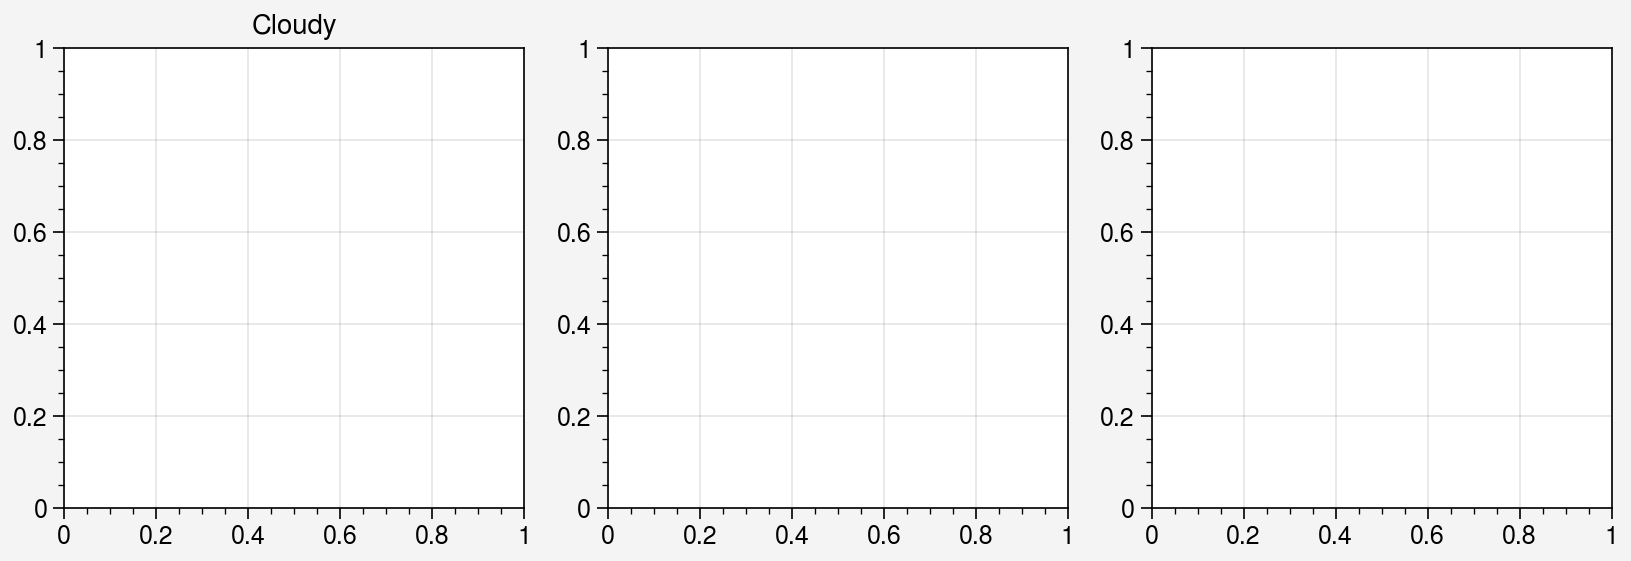

In [78]:
import proplot as pplt
import numpy as np

# Histogram with marginal distributions
fig, axs = pplt.subplots(ncols=3, refwidth=2.3, share=False)

# can loop this with some care



ax = axs[0]

ax.format(titleabove=True,
    title='Cloudy'
)

for ax, category, color in zip(axs, ['cloudy', 'cloudy_ice', 'clearsky_ice'], ['steelblue', 'tangerine', 'tab:green']):

    idx = pixel_data[category].training
    x = pixel_data[category].loc[idx, 'b2']
    y = pixel_data[category].loc[idx, 'b7']

    bins = np.linspace(0, 256, 33)
    binc = 0.5*(bins[1:] + bins[:-1])
    H, _, _ = np.histogram2d(x, y, bins=[bins, bins])
    H = H.T
    ax.pcolormesh(binc, binc, np.log(np.ma.masked_array(H, H <= 5)),
              vmin=np.log(5), vmax=15, levels=30,
              cmap='PuBu_r', colorbar='b', colorbar_kw={'label': 'Log Count', 'rotation': 45})
    ax.format(titleabove=True, title=category)
    px = ax.panel('r', space=0)
    px.histh(y, bins, color=color, fill=True, ec='k')
    px.format(grid=False, xlocator=[], ylabel='Band 7 Brightness', xreverse=False)
    
    px = ax.panel('t', space=0)
    px.hist(x, bins, color=color, fill=True, ec='k')
    px.format(grid=False, ylocator=[])



# fig.save('../figures/cloud_mask_histograms.png', dpi=300)
tau_init = 110
tau_b2 = 190
tau_b7 = 200
tau_b7b2 = 0.75
for ax in axs:
    ax.axhline(tau_b7, ls='-', label='B7 < tau_7', lw=1, color='tab:purple')
    ax.axvline(tau_b2, ls='-', label='B2 < tau_2', lw=1, color='tab:purple')
    ax.axhline(tau_init, ls='--', label='B7 > tau_0', lw=1, color='tab:orange')
    ax.plot([0, 255], [0, tau_b7b2*255], color='tab:green', lw=1)
    
    # draw solid line 
    # This version is if the crossing is above the line and the b7/b2 threshold continues
    ax.plot([0, tau_init/tau_b7b2, tau_b2, tau_b2, tau_b7/tau_b7b2, 256],
            [tau_init, tau_init, tau_b2*tau_b7b2, tau_b7, tau_b7, 256*tau_b7b2], color='k', lw=3)

    ax.plot([0, tau_b2, tau_b2, tau_b7/tau_b7b2],
            [tau_init, tau_init, tau_b2*tau_b7b2, tau_b7], color='gold', lw=2, ls='--')

fig.save('../figures/cloud_mask_histograms_alt_lines2.png', dpi=300)

Parameter sweep:

In [187]:
def pixel_generate_masks(b7, b2, t7=200, t2=190, r_lower=0, r_upper=0.75, t0=110, variant="LA2019"):
    """Generate the all-cloud and opaque-cloud masks. Opaque cloud mask is defined as a subset
    of the all-cloud mask where the ice floes are visible. Masks are vectors."""
    
    all_cloud = b7 > t0 # true == cloudy pixel
    mask_b7b2 = (b7 < t7) & (b2 > t2) # true == thin cloud
    mask_ratio = b7/b2
    mask_cloud_ice = (mask_ratio > r_lower) & (mask_ratio < r_upper)
    mask_cloud_ice = mask_cloud_ice & mask_b7b2
    if variant == "LA2019":
        ice_mask = ~(mask_cloud_ice & ~all_cloud)
    else:
        ice_mask = ~(mask_cloud_ice | ~all_cloud)
    return all_cloud, ice_mask

In [191]:
ac, im = pixel_generate_masks(pixel_data['cloudy']['b7'], 
                              pixel_data['cloudy']['b2'])
pixel_data['cloudy']['all_cloud_LA2019'] = ac
pixel_data['cloudy']['unmasked_sea_ice'] = im

ac, im = pixel_generate_masks(pixel_data['cloudy']['b7'], 
                              pixel_data['cloudy']['b2'], variant='other')
pixel_data['cloudy']['all_cloud_alt_interp'] = ac
pixel_data['cloudy']['unmasked_sea_ice_interp'] = im

In [189]:
print("Cloud fraction correct, LA2019", pixel_data['cloudy']['all_cloud_LA2019'].mean())
print("Cloud fraction correct, ALTMETHOD", pixel_data['cloudy']['all_cloud_LA2019'].mean())

0.7363908775709781

In [78]:
%%time
training_data = pd.concat([cloudy_ice[cloudy_ice['training']], clear_ice[clear_ice['training']]])
training_data['b7b2'] = training_data['b7']/training_data['b2'].where(training_data['b2'] > 50)
training_data = training_data.dropna()
sweep_results = []
for b2_threshold in np.arange(100, 225, 10):
    
    ice_pix = training_data.loc[(training_data['b2'] <= b2_threshold) & (training_data['b2'] > 50)]
    if len(ice_pix) > 1000:
        for R_threshold in np.arange(0.1, 1, 0.1):
            b7_min = R_threshold*b2_threshold
            if b7_min <= 200:
                for b7_threshold in np.arange(round(b7_min), 225, 10):
                    fp = cloud_mask(training_data['b2'], training_data['b7'], t0=15,
                                    t_b7=b7_threshold, t_b2=b2_threshold, t_b7b2=R_threshold)
                    tp = cloud_mask(cloudy.loc[cloudy.training, 'b2'], cloudy.loc[cloudy.training, 'b7'],
                                   t_b7=b7_threshold, t_b2=b2_threshold, t_b7b2=R_threshold)
                    F1 = 2*np.sum(tp)/(2*np.sum(tp) + np.sum(fp) + np.sum(~tp))
                    sweep_results.append([b2_threshold, R_threshold, b7_threshold, np.round(F1, 2)])

CPU times: user 2min 43s, sys: 39.5 s, total: 3min 22s
Wall time: 3min 23s


In [75]:
b7_threshold = 100
b2_threshold = 200
R_threshold = 0.5
fp = cloud_mask(training_data['b2'], training_data['b7'], t0=15,
                t_b7=b7_threshold, t_b2=b2_threshold, t_b7b2=R_threshold)
tp = cloud_mask(cloudy.loc[cloudy.training, 'b2'], cloudy.loc[cloudy.training, 'b7'],
               t_b7=b7_threshold, t_b2=b2_threshold, t_b7b2=R_threshold)
F1 = 2*np.sum(tp)/(2*np.sum(tp) + np.sum(fp) + np.sum(~tp))

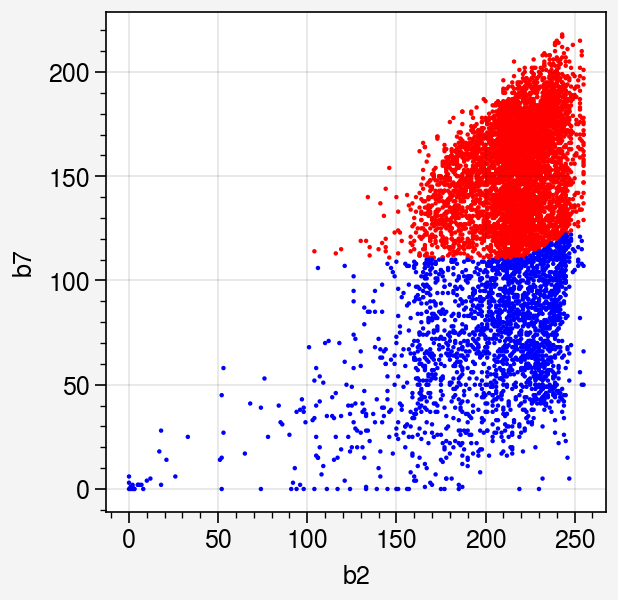

In [76]:
fig, ax = pplt.subplots()
ax.scatter(cloudy.loc[cloudy.training, 'b2'][::1000], cloudy.loc[cloudy.training, 'b7'][::1000],
           c=tp.astype(int)[::1000], cmap='bwr', ms=1)

The f1 score is the harmonic mean of the precision and the recall. In this case, we are considering pixels that have known values of "cloudy" or "ice". We've pooled together the clear-sky and the cloudy ice. The exhaustive parameter search using the f1 score lets us simultaneously vary each of the settings, though there's not much sensitivity in any cases where the b2 and b7 intersection is less than R. 

In [54]:
sweep_results = pd.DataFrame(sweep_results, columns=['b2', 'R', 'b7', 'f1'])

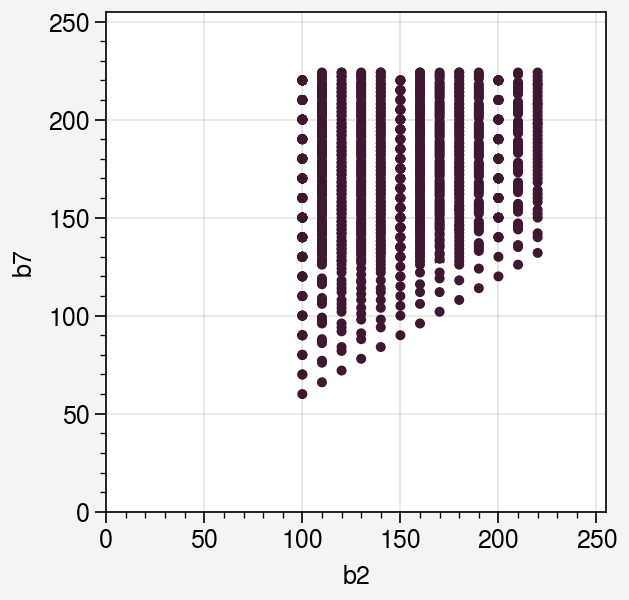

In [63]:
fig, ax = pplt.subplots()
ax.scatter(sweep_results['b2'], sweep_results['b7'], marker='.', c=sweep_results['f1'])
ax.format(ylim=(0, 255), xlim=(0, 255))

In [ ]:
print('Default settings')
clouds = cloud_mask(b2_cloud, b7_cloud)
print('Cloud pixels covered: ', np.round(np.mean(clouds), 2)*100, '%')
icecloud = cloud_mask(b2_ice_cloud, b7_ice_cloud)
print('Cloud-obscured ice pixels covered: ', np.round(np.mean(icecloud), 2)*100, '%')
ice = cloud_mask(b2_ice_nocloud, b7_ice_nocloud)
print('Ice pixels covered: ', np.round(np.mean(ice), 2)*100, '%')

In [ ]:
tau_init = 13
tau_b2 = 180
tau_b7 = 180
tau_b7b2 = 0.8
print('Fit mask vs cloud-covered ice')
clouds = cloud_mask(b2_cloud, b7_cloud, t0=tau_init, t_b7=tau_b7, t_b2=tau_b2, t_b7b2=tau_b7b2)
print('Cloud pixels covered: ', np.round(np.mean(clouds), 2)*100, '%')
icecloud = cloud_mask(b2_ice_cloud, b7_ice_cloud, t0=tau_init, t_b7=tau_b7, t_b2=tau_b2, t_b7b2=tau_b7b2)
print('Cloud-obscured ice pixels covered: ', np.round(np.mean(icecloud), 2)*100, '%')
ice = cloud_mask(b2_ice_nocloud, b7_ice_nocloud, t0=tau_init, t_b7=tau_b7, t_b2=tau_b2, t_b7b2=tau_b7b2)
print('Ice pixels covered: ', np.round(np.mean(ice), 2)*100, '%')

In [ ]:
tau_init = 13
tau_b2 = 180
tau_b7 = 80
tau_b7b2 = 0.4
print('Fit mask vs clear-sky ice')
clouds = cloud_mask(b2_cloud, b7_cloud, t0=tau_init, t_b7=tau_b7, t_b2=tau_b2, t_b7b2=tau_b7b2)
print('Cloud pixels covered: ', np.round(np.mean(clouds), 2)*100, '%')
icecloud = cloud_mask(b2_ice_cloud, b7_ice_cloud, t0=tau_init, t_b7=tau_b7, t_b2=tau_b2, t_b7b2=tau_b7b2)
print('Cloud-obscured ice pixels covered: ', np.round(np.mean(icecloud), 2)*100, '%')
ice = cloud_mask(b2_ice_nocloud, b7_ice_nocloud, t0=tau_init, t_b7=tau_b7, t_b2=tau_b2, t_b7b2=tau_b7b2)
print('Ice pixels covered: ', np.round(np.mean(ice), 2)*100, '%')

NameError: name 'b2_ice_nocloud' is not defined

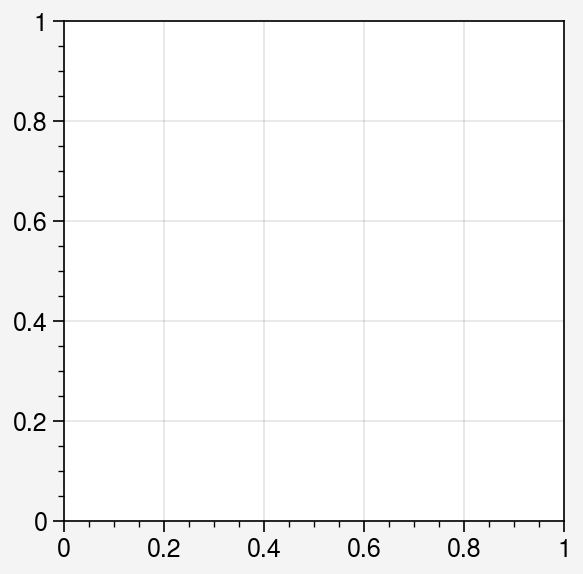

In [113]:
fig, ax = pplt.subplots()
bins = np.linspace(0, 256, 33)
binc = 0.5*(bins[1:] + bins[:-1])
H, _, _ = np.histogram2d(b2_ice_nocloud, b7_ice_nocloud, bins=[bins, bins])
H = H.T
ax.contour(binc, binc, np.log(np.ma.masked_array(H, H == 0)),
              vmin=np.log(5), vmax=10, levels=5, lw=2,
              c='k')


H, _, _ = np.histogram2d(b2_ice_cloud, b7_ice_cloud, bins=[bins, bins])
H = H.T
ax.contour(binc, binc, np.log(np.ma.masked_array(H, H == 0)),
              vmin=np.log(5), vmax=10, levels=5, lw=1,
              c='r')

H, _, _ = np.histogram2d(b2_cloud, b7_cloud, bins=[bins, bins])
H = H.T
ax.contourf(binc, binc, np.log(np.ma.masked_array(H, H == 0)),
              vmin=np.log(5), vmax=10, levels=5, lw=1,
              cmap='blues', extend='both', alpha=0.5)

h = [ax.plot([],[],ls='-', c='k', lw=2),
     ax.plot([],[],ls='-', c='r', lw=2),
     ax.plot([],[],ls='-', c='steelblue', lw=10)]
ax.legend(h, ['Clear-sky ice', 'Cloud-obscured ice', 'Cloud'], ncols=1, loc='ul')
 

# Example image

# Strategies to estimate the parameters for the cloud mask
What defines a good set of parameters?
1. Pixels known to have sea ice are not masked.
2. As many cloudy pixels are masked as possible.
3. If possible without strongly degrading the cloud mask, allow cloud-covered sea ice pixels to be unmasked.

Method one: quantile-based
1. Use the clear sky sea ice pixels as a reference.
2. Specify a Band 2 threshold.
3. Set the ratio threshold = 99th percentile of B7/B2 for the pixels with B2 <= threshold
4. Set the band 7 threshold as the 99th percentile for the set of pixels with B2 > threshold. If below the ratio * B2, set to ratio * B2.

Method two: 
1. Use the clear sky sea ice pixels as a reference.
2. Specify a Band 2 threshold.
3. Calculate the B7/B2 ratio threshold based on 1.5 $\times$ IQR for pixels with B2 < threshold.
4. Calculate B7 threshold based on 1.5 $\times$ IQR for pixels with B2 > threshold. If below ratio * B2, set to ratio * B2.

Method three:
1. Specify a Band 2 threshold.
2. Find the value of the ratio that solves a max-min for covering as much of the cloud as possible with as little of the ice as possible.


In [ ]:
tau_b2 = 180
get_thresholds(tau_b2, b2_ice_nocloud, b7_ice_nocloud, method='quantile')

In [ ]:
get_thresholds(tau_b2, b2_ice_nocloud, b7_ice_nocloud, method='iqr_outlier')

NameError: name 'b2_cloud' is not defined

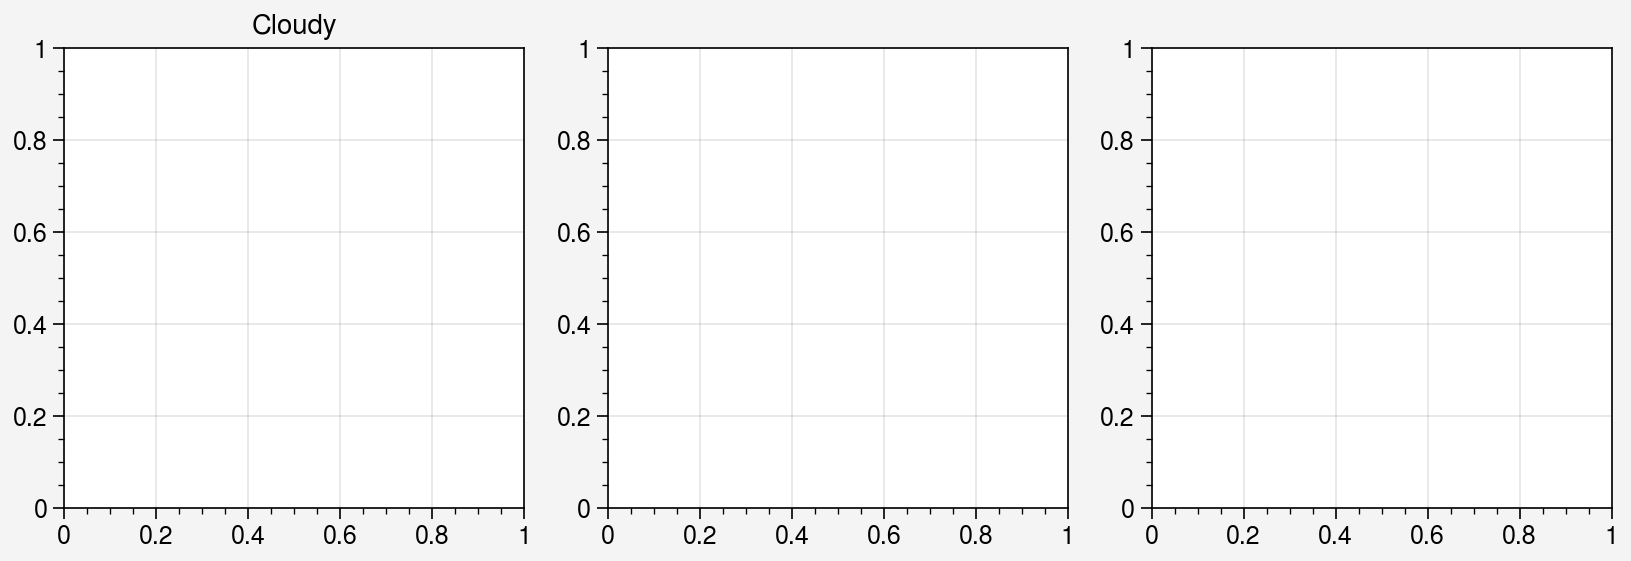

In [115]:
import proplot as pplt
import numpy as np

# Histogram with marginal distributions
fig, axs = pplt.subplots(ncols=3, refwidth=2.3, share=False)

# can loop this with some care
ax = axs[0]

ax.format(titleabove=True,
    title='Cloudy'
)

color = 'steelblue'
x = b2_cloud.copy()
y = b7_cloud.copy()

bins = np.linspace(0, 256, 33)
binc = 0.5*(bins[1:] + bins[:-1])
H, _, _ = np.histogram2d(x, y, bins=[bins, bins])
H = H.T
ax.pcolormesh(binc, binc, np.log(np.ma.masked_array(H, H <= 5)),
              vmin=np.log(5), vmax=15, levels=30,
              cmap='PuBu_r', colorbar='b', colorbar_kw={'label': 'Log Count', 'rotation': 45})

# color = pplt.scale_luminance(color, 1.5)  # histogram colors
px = ax.panel('r', space=0)
px.histh(y, bins, color=color, fill=True, ec='k')
px.format(grid=False, xlocator=[], ylabel='Band 7 Brightness', xreverse=False)

px = ax.panel('t', space=0)
px.hist(x, bins, color=color, fill=True, ec='k')
px.format(grid=False, ylocator=[])

ax = axs[1]
color = 'tangerine'
x = b2_ice_cloud.copy()
y = b7_ice_cloud.copy()
ax.format(titleabove=True,
    title='Cloud-obscured Ice'
)

H, _, _ = np.histogram2d(x, y, bins=[bins, bins])
H = H.T
ax.pcolormesh(binc, binc, np.log(np.ma.masked_array(H, H <= 5)),
              vmin=np.log(5), vmax=10, levels=30,
              cmap='PuBu_r', colorbar='b', colorbar_kw={'label': 'Log Count', 'rotation': 45})

# color = pplt.scale_luminance(color, 1.5)  # histogram colors
px = ax.panel('r', space=0)
px.histh(y, bins, color=color, fill=True, ec='k')
px.format(grid=False, xlocator=[], ylabel='Band 7 Brightness', xreverse=False)

px = ax.panel('t', space=0)
px.hist(x, bins, color=color, fill=True, ec='k')
px.format(grid=False, ylocator=[])
axs.format(ylim=(0, 255), xlim=(0, 255))

x = b2_ice_nocloud.copy()
y = b7_ice_nocloud.copy()
ax = axs[2]
color='tab:green'
ax.format(titleabove=True,
    title='Clear-sky ice'
)

H, _, _ = np.histogram2d(x, y, bins=[bins, bins])
H = H.T
ax.pcolormesh(binc, binc, np.log(np.ma.masked_array(H, H <= 5)),
              vmin=np.log(5), vmax=10, levels=30,
              cmap='PuBu_r', colorbar='b', colorbar_kw={'label': 'Log Count', 'rotation': 45})

px = ax.panel('r', space=0)
px.histh(y, bins, color=color, fill=True, ec='k')
px.format(grid=False, xlocator=[], ylabel='Band 7 Brightness', xreverse=False)

px = ax.panel('t', space=0)
px.hist(x, bins, color=color, fill=True, ec='k')
px.format(grid=False, ylocator=[])
axs.format(ylim=(0, 255), xlim=(0, 255), xlabel='Band 2 Brightness')

fig.save('../figures/cloud_mask_histograms.png', dpi=300)

tau_init = 110
tau_b2 = 190
tau_b7 = 200
tau_b7b2 = 0.75
for ax in axs:
    ax.axhline(tau_b7, ls='-', label='B7 < tau_7', lw=1, color='tab:purple')
    ax.axvline(tau_b2, ls='-', label='B2 < tau_2', lw=1, color='tab:purple')
    ax.axhline(tau_init, ls='--', label='B7 > tau_0', lw=1, color='tab:orange')
    ax.plot([0, 255], [0, tau_b7b2*255], color='tab:green', lw=1)

    # draw solid line
    ax.plot([0, tau_init/tau_b7b2, tau_b2, tau_b2, 256],
            [tau_init, tau_init, tau_b2*tau_b7b2, tau_b7, tau_b7], color='k', lw=2)

fig.save('../figures/cloud_mask_histograms_default_lines.png', dpi=300)




In [ ]:
# Range for the b2_ice_nocloud case:
# Less than 1% of the ice data has b2 less than 118 or greater than 246
# 95% of the data is between 162 and 242. 
np.quantile(b2_ice_nocloud, [0.005, 0.995])
np.quantile(b2_ice_nocloud, [0.025, 0.975])

In [ ]:
candidate_b2 = np.arange(150, 250, 5)
nocloud_results = []
for tau_b2 in candidate_b2:
    tau_b7, tau_b7b2 = get_thresholds(tau_b2, b2_ice_nocloud, b7_ice_nocloud, method='quantile')
    tau_init, tau_b2, tau_b7, tau_b7b2

    cloud_err = compute_error(tau_init, tau_b2, tau_b7, tau_b7b2, b2_cloud, b7_cloud)
    ice_cloud_err = 1-compute_error(tau_init, tau_b2, tau_b7, tau_b7b2, b2_ice_cloud, b7_ice_cloud)
    ice_err = 1-compute_error(tau_init, tau_b2, tau_b7, tau_b7b2, b2_ice_nocloud, b7_ice_nocloud)
    nocloud_results.append([tau_b2, tau_b7, tau_b7b2, cloud_err, ice_cloud_err, ice_err])
nocloud_results = pd.DataFrame(nocloud_results, columns=['tau_b2', 'tau_b7', 'tau_b7b2', 'cloud_err', 'ice_cloud_err', 'ice_err'])

candidate_b2 = np.arange(150, 250, 5)
icecloud_results = []
for tau_b2 in candidate_b2:
    tau_b7, tau_b7b2 = get_thresholds(tau_b2, b2_ice_cloud, b7_ice_cloud,  method='quantile')

    cloud_err = compute_error(tau_init, tau_b2, tau_b7, tau_b7b2, b2_cloud, b7_cloud)
    ice_cloud_err = 1-compute_error(tau_init, tau_b2, tau_b7, tau_b7b2, b2_ice_cloud, b7_ice_cloud)
    ice_err = 1-compute_error(tau_init, tau_b2, tau_b7, tau_b7b2, b2_ice_nocloud, b7_ice_nocloud)
    icecloud_results.append([tau_b2, tau_b7, tau_b7b2, cloud_err, ice_cloud_err, ice_err])
icecloud_results = pd.DataFrame(icecloud_results, columns=['tau_b2', 'tau_b7', 'tau_b7b2', 'cloud_err', 'ice_cloud_err', 'ice_err'])

In [ ]:
nocloud_results['cross_below_ratio'] = nocloud_results['tau_b7']/nocloud_results['tau_b2'] < nocloud_results['tau_b7b2']
icecloud_results['cross_below_ratio'] = icecloud_results['tau_b7']/icecloud_results['tau_b2'] < icecloud_results['tau_b7b2']

In [ ]:
nocloud_results

In [ ]:
compute_error(110, 200, 190, 0.75, b2_cloud, b7_cloud)

In [ ]:
1 - compute_error(110, 200, 190, 0.75, b2_ice_nocloud, b7_ice_nocloud)

In [ ]:
fig, ax = pplt.subplots()
ax.plot(nocloud_results['tau_b2'].values,
        nocloud_results['cloud_err'].values, label='Cloud Error', c='b')
ax.plot(nocloud_results['tau_b2'].values, nocloud_results['ice_cloud_err'].values,
        label='Cloudy Ice Error', c='r')
ax.plot(nocloud_results['tau_b2'].values, nocloud_results['ice_err'].values,
        label='Ice Error', c='k')

ax.plot(icecloud_results['tau_b2'].values, icecloud_results['cloud_err'].values,
        label='Cloud Error (cloudy ice)', c='b', ls='--')
ax.plot(icecloud_results['tau_b2'].values, icecloud_results['ice_cloud_err'].values,
        label='Cloudy Ice Error (cloudy ice)', c='r', ls='--')
ax.plot(icecloud_results['tau_b2'].values, icecloud_results['ice_err'].values,
        label='Ice Error (cloudy ice)', c='k', ls='--')
ax.legend(loc='r', ncols=1)
ax.format(ylim=(0, 1))

In [ ]:
fig, axs = pplt.subplots(ncols=1)
# Init clouds
ax = axs[0]
X = np.zeros((255, 255))
for ii in range(255): # y axis 
    for jj in range(255): # x axis
        set1 = jj > 110
        set2 = (ii > 190) & (jj < 200)
        set3 = jj/(ii + 0.001) < 0.75
        if set1 & ~(set2 | set3):
            X[ii, jj] = 1
ax.pcolormesh(np.arange(255), np.arange(255), np.ma.masked_array(X.T, X.T==0), alpha=0.5, c='r')
ax.axvline(190, ls='-', lw=1, color='tab:purple')
ax.axhline(200, ls='-', label='B2 < tau_2', lw=1, color='tab:purple')
ax.axhline(110, ls='--', label='B7 > tau_0', lw=1, color='tab:orange')
ax.plot([0, 255], [0, 0.75*255], color='tab:green', lw=1)
ax.format(title='Original mask', ylabel='B$_7$ Corrected Reflectance', xlabel='B$_2$ Corrected Reflectance')
fig.save('../figures/init_mask_schematic.png', dpi=300)

In [ ]:
tau_b7, tau_b7b2 = get_thresholds(tau_b2, b2_ice_nocloud, b7_ice_nocloud,  method='quantile')


In [ ]:
fig, axs = pplt.subplots(ncols=2)
# Init clouds
ax = axs[0]
X = np.zeros((255, 255))
for ii in range(255): # y axis 
    for jj in range(255): # x axis
        set1 = jj > 110
        set2 = (ii > 190) & (jj < 200)
        set3 = jj/(ii + 0.001) < 0.75
        if set1 & ~(set2 | set3):
            X[ii, jj] = 1
ax.pcolormesh(np.arange(255), np.arange(255), np.ma.masked_array(X.T, X.T==0), alpha=0.5, c='r')
ax.axvline(190, ls='-', lw=1, color='tab:purple')
ax.axhline(200, ls='-', label='B2 < tau_2', lw=1, color='tab:purple')
ax.axhline(110, ls='--', label='B7 > tau_0', lw=1, color='tab:orange')
ax.plot([0, 255], [0, 0.75*255], color='tab:green', lw=1)
ax.format(title='Original mask', ylabel='B7 Pixel Intensity', xlabel='B2 Pixel Intensity')

ax = axs[1]
tau_init = 13
tau_b2 = 180
tau_b7, tau_b7b2 = get_thresholds(tau_b2, b2_ice_nocloud, b7_ice_nocloud,  method='quantile')
print(tau_b2, tau_b7, tau_b7b2)
X = np.zeros((255, 255))
for ii in range(255): # y axis 
    for jj in range(255): # x axis
        set1 = jj > tau_init
        set2 = (ii > tau_b2) & (jj < tau_b7)
        set3 = jj/(ii + 0.001) < tau_b7b2
        if set1 & ~(set2 | set3):
            X[ii, jj] = 1

bins = np.linspace(0, 256, 33)
binc = 0.5*(bins[1:] + bins[:-1])
H, _, _ = np.histogram2d(b2_ice_cloud, b7_ice_cloud, bins=[bins, bins])
H = H.T
for ax in axs:
    ax.contour(binc, binc, np.log(np.ma.masked_array(H, H == 0)),
              vmin=np.log(5), vmax=10, levels=5, lw=2,
              c='k')

H, _, _ = np.histogram2d(b2_cloud, b7_cloud, bins=[bins, bins])
H = H.T
for ax in axs:
    ax.contour(binc, binc, np.log(np.ma.masked_array(H, H == 0)),
              vmin=np.log(5), vmax=10, levels=5, lw=1,
              c='b')


ax.pcolormesh(np.arange(255), np.arange(255), np.ma.masked_array(X.T, X.T==0), alpha=0.25, c='b')
ax.axvline(tau_b2, ls='-', label='B7 < tau_7', lw=1, color='tab:purple')
ax.axhline(tau_b7, ls='-', label='B2 < tau_2', lw=1, color='tab:purple')
ax.axhline(tau_init, ls='--', label='B7 > tau_0', lw=1, color='tab:orange')
ax.format(title='Updated mask')
ax.plot([0, 255], [0, tau_b7b2*255], color='tab:green', lw=1)

In [ ]:
fig, ax = pplt.subplots()
bins = np.linspace(0, 256, 33)
binc = 0.5*(bins[1:] + bins[:-1])
H, _, _ = np.histogram2d(b2_ice_nocloud, b7_ice_nocloud, bins=[bins, bins])
H = H.T
ax.contour(binc, binc, np.log(np.ma.masked_array(H, H == 0)),
              vmin=np.log(5), vmax=10, levels=5, lw=2,
              c='k')


H, _, _ = np.histogram2d(b2_ice_cloud, b7_ice_cloud, bins=[bins, bins])
H = H.T
ax.contour(binc, binc, np.log(np.ma.masked_array(H, H == 0)),
              vmin=np.log(5), vmax=10, levels=5, lw=1,
              c='r')

H, _, _ = np.histogram2d(b2_cloud, b7_cloud, bins=[bins, bins])
H = H.T
ax.contourf(binc, binc, np.log(np.ma.masked_array(H, H == 0)),
              vmin=np.log(5), vmax=10, levels=5, lw=1,
              cmap='blues', extend='both', alpha=0.5)

h = [ax.plot([],[],ls='-', c='k', lw=2),
     ax.plot([],[],ls='-', c='r', lw=2),
     ax.plot([],[],ls='-', c='steelblue', lw=10)]
ax.legend(h, ['Clear-sky ice', 'Cloud-obscured ice', 'Cloud'], ncols=1, loc='ul')
 

## Surprising but not hard to interpret results
1. The clear-sky sea ice pixels essentially always come through just fine
2. We get nearly as good results just using the ratio
3. We can include more cloud-covered ice by adding the bump, but that comes at a cost
4. Need to check other methods for getting the lines, perhaps based on getting the per

In [ ]:
tau_b7, tau_b7b2 = get_thresholds(tau_b2, b2_ice_cloud, b7_ice_cloud,  method='quantile')
print(tau_b2, tau_b7, tau_b7b2)

In [ ]:
import skimage

case = '056_aqua'

region = df.loc[case,'region']
cf_manual = (df.loc[case, 'cloud_fraction_manual']*100).round(0)
cf_modis = (df.loc[case, 'cloud_fraction_modis']*100).round(0)

fig, axs = pplt.subplots(ncols=3, nrows=2)

# first few images have a single array
clouds_view_init, cloud_mask_init = generate_masks(fc_images[case], t1=200, t2=190,
                                                   r_lower=0, r_upper=0.75, tc=110)
layered_mask_init = ((cloud_mask_init).astype(float) + clouds_view_init.astype(float))/2

clouds_view_new, cloud_mask_new = generate_masks(fc_images[case], t1=180, t2=80, r_lower=0, r_upper=0.4, tc=13)
layered_mask_new = ((cloud_mask_new).astype(float) + clouds_view_new.astype(float))/2

for ax, data, title in zip(axs, 
                [tc_images[case], fc_images[case], cf_images[case], layered_mask_init, layered_mask_new],
                ['TC Image', 'FC Image', 'Cloud Fraction (%)', 'Default Cloud Mask', 'Updated Cloud Mask']):
    if title in ['TC Image', 'FC Image']:
        ax.imshow(reshape_as_image(data))
    elif title == 'Cloud Fraction (%)':
        c = ax.pcolormesh(data.values, vmin=0, vmax=100, N=17, cmap='Blues')
        ax.colorbar(c, label='Cloud Fraction (%)')
        ax.format(urtitle='Manual: {c0}%\nModis: {c1}'.format(c0=cf_manual, c1=cf_modis))
    elif 'Mask' in title:
        c = ax.pcolormesh(data, N=3, cmap='blues')
        ax.colorbar(c, ticks=[.2, 0.6, 1], loc='b', alpha=1, ticklabels=['Clear', 'Unmask', 'Mask'], ticklen=0.1)
        manual_floe_labels = lb_images[case][0,:,:] % 2
        outlines = manual_floe_labels - skimage.morphology.erosion(manual_floe_labels, skimage.morphology.disk(4))
        ax.pcolormesh(np.ma.masked_array(outlines, outlines==0), color='r', alpha=0.5)

    ax.format(title=title, yreverse=True)





# # plot MASIE data
# ax = axs[1, 1]
# masie_ice = mi_images[case].squeeze()
# masie_land = ml_images[case].squeeze()
# ax.imshow(np.ma.masked_array(masie_land, mask=masie_land != 1), c='steelblue')
# ax.imshow(np.ma.masked_array(masie_ice, mask=masie_ice==0), c='w')
# ax.imshow(np.ma.masked_array(masie_land, mask=masie_land != 2), c='gray')
# ax.imshow(np.ma.masked_array(masie_land, mask=masie_land != 4), c='darkgray')
# h = []
# for c in ['steelblue', 'w', 'lightgray', 'darkgray']:
#     h.append(ax.plot([],[],m='s', lw=0, c=c, edgecolor='k'))
# ax.legend(h, ['Water', 'Ice', 'Coast', 'Land'], loc='b', ncols=2)
# ax.format(title='MASIE')


# plot manual label data
ax = axs[1, 2]
binary_land = lm_images[case][0,:,:]
clouds25 = (cf_images[case] >= 25).astype(int)
clouds50 = (cf_images[case] >= 50).astype(int)
clouds = (clouds25 + clouds50)/2

ax.imshow(np.ma.masked_array(binary_land, mask=binary_land == 0), c='gray9')
if case in lb_images:
    manual_ice = lb_images[case][0,:,:]
    ax.imshow(np.ma.masked_array(manual_ice, mask=manual_ice==0), c='red5')
else:
    ax.format(ultitle='No ice mask')
    
if case in lf_images:
    manual_landfast = lf_images[case][0,:,:]
    ax.imshow(np.ma.masked_array(manual_landfast, mask=manual_landfast == 0), c='yellow4')
else:
    ax.format(urtitle='No landfast mask')

ax.imshow(np.ma.masked_array(clouds, mask=clouds==0), cmap='Blues', vmin=0, vmax=2, alpha=0.5)
    
h = []
for c in ['red5', 'yellow4', 'darkgray', 'lightblue']:
    h.append(ax.plot([],[],m='s', lw=0, c=c, edgecolor='k'))
ax.legend(h, ['Sea Ice', 'Landfast Ice', 'Land', 'MODIS cloud'], loc='b', ncols=2)
ax.format(title='Manual labels')

axs.format(yreverse=True, suptitle=case.replace('_', ' ') + ' ' + region.replace('_', ' ').title())
# fig.save('../figures/overview_images/' + case + '_' + region + '_overview.png', dpi=300)

In [ ]:
print("B7 percentiles: 95, 99, 99.9%")
print("Cloud:   ", np.quantile(b7_cloud, [0.95, 0.99, 0.999]))
print("IceCld:  ", np.quantile(b7_ice_cloud, [0.95, 0.99, 0.999]))
print("IceNoCld:", np.quantile(b7_ice_nocloud, [0.95, 0.99, 0.999]))

In [ ]:
print("B7 percentiles: 95, 99, 99.9%")
print("Cloud:   ", np.quantile(b2_cloud, [0.95, 0.99, 0.999]))
print("IceCld:  ", np.quantile(b2_ice_cloud, [0.95, 0.99, 0.999]))
print("IceNoCld:", np.quantile(b2_ice_nocloud, [0.95, 0.99, 0.999]))

In [ ]:
fig, ax = pplt.subplots()
r = b7_ice_nocloud / b2_ice_nocloud
r = r[b2_ice_nocloud < 210]
r = r[r > 0]
r = r[r < 10e5]
_ = ax.hist(r, bins=np.linspace(0, 1, 50), alpha=0.5, density=True)

r = b7_ice_cloud / b2_ice_cloud
r = r[b2_ice_cloud < 210]
r = r[r > 0]
r = r[r < 10e5]
_ = ax.hist(r, bins=np.linspace(0, 1, 50), alpha=0.5, density=True)

r = b7_cloud / b2_cloud
r = r[b2_cloud < 210]
r = r[r > 0]
r = r[r < 10e5]
_ = ax.hist(r, bins=np.linspace(0, 1, 50), alpha=0.5, density=True)

Some takeaways:
- I'll need to define a tolerance for weighing the performance with the position of each line. How much is acceptable to miss in each category?
- The cloud category has a pretty major overlap with the ice-cloud category. How can I make sure that I'm not including the cases where there are not-yet-labeled ice floes? Or clearly visible ice?
- What kind of penalty should there be for uncovering regions where no visible sea ice is there?

# Evaluating best choices for ratios
We can use the manually labeled dataset to identify thresholds and/or breakpoints. Many images are essentially 100% opaque clouds (though to be fair some of those may include sea ice with no visible floes. We'll need to select a training and testing portion of the dataset. I think the final mask should also be cleaned up so that objects smaller than, say 100 pixels, are removed from the mask. 

1. Clouds
   1. Cloud fraction > 80%
   2. Cloud type = Opaque
   3. No visible sea ice
2. Sea ice floes, clear skies
   1. Cloud fraction < 0.2
   2. Visible floes -- verify manually
   3. Compute average of estimated cloud fraction within floe
3. Sea ice floes, cloud-obscured
   1. Visible floes
   2. Cloud type thin
   3. Compte average of estimated cloud fraction within floe
4. Open water
   1. Use the MASIE ice fraction and the landmask / 

* definitely clouds
  * opaque clouds, higher than 90% cloud cover
* definitely open water
* maybe one of those but it's unclear

Ratio B7 to B2: this is the ratio of band 7 to band 1. 
- Pixels with water tend to be dark, and have higher values of the threshold.
- Pixels with snow and ice tend to have low ratios.

NSDII2: a normalized ratio of bands 4 and 2 (band 4 = 0.55, band 2 = 0.84). Band 7 is 2.1, Band 1 is 0.65, Band 3=0.46

One description of NDSI is (R1 - R2)/(R1 + R2), where R1 is visible and R2 is shortwave infrared. So in the initial modis algorithm, they'd used band 4 for R1, and used band 6 for R2, but that band is missing in Aqua. So 

Conditions 1-2: pretty good for separating ice and water, but not perfect


`


In [ ]:
df.loc[(df.cloud_fraction_manual > 0.8) & (df.visible_sea_ice=='no')]

In [ ]:
case = "048_aqua"
# clouds_view = fc_images[case][0,:,:] > tc # true == cloudy pixel
b4 = tc_images[case][1,:,:]
b7 = fc_images[case][0,:,:]
b2 = fc_images[case][1,:,:]

nsdii2 = (b4 - b2)/(b4 + b2)
mask_ratio = b7/b2
floes = np.ravel(lb_images[case])
nsdii2_data = np.ravel(nsdii2)
nsdii2_data = nsdii2_data[~np.isnan(nsdii2_data)]
nsdii2_data = nsdii2_data[nsdii2_data <= 2]

ratio_data = np.ravel(mask_ratio)
ratio_data = ratio_data[~np.isnan(ratio_data)]
ratio_data = ratio_data[ratio_data <= 2]

nsdi = (b2 - b7)/(b2 + b7) # alternative from VIIRS paper
nsdi_data = np.ravel(nsdi)
nsdi_data = nsdi_data[~np.isnan(nsdi_data)]
nsdi_data = nsdi_data[nsdi_data <= 2]


fig, ax = pplt.subplots(width=5, height=3)
_ = ax.hist(nsdii2_data, bins=np.linspace(0, 2, 100), alpha=0.5, label='NSDII2')
_ = ax.hist(ratio_data, bins=np.linspace(0, 2, 100), alpha=0.5, label='B7/B2')
_ = ax.hist(nsdi_data, bins=np.linspace(0, 2, 100), alpha=0.5, label='NSDI_alt')

ax.legend(ncols=1)

In [ ]:
# 
case = "048_aqua"
# clouds_view = fc_images[case][0,:,:] > tc # true == cloudy pixel
b4 = tc_images[case][1,:,:]
b7 = fc_images[case][0,:,:]
b2 = fc_images[case][1,:,:]

nsdii2 = (b4 - b2)/(b4 + b2)
mask_ratio = b7/b2
floes = np.ravel(lb_images[case])
nsdii2_data = np.ravel(nsdii2)
nsdii2_data = nsdii2_data[~np.isnan(nsdii2_data)]
nsdii2_data = nsdii2_data[nsdii2_data <= 2]

ratio_data = np.ravel(mask_ratio)
ratio_data = ratio_data[~np.isnan(ratio_data)]
ratio_data = ratio_data[ratio_data <= 2]

fig, ax = pplt.subplots(width=5, height=3)
_ = ax.hist(nsdii2_data, bins=np.linspace(0, 2, 100), alpha=0.5, label='NSDII2')
_ = ax.hist(ratio_data, bins=np.linspace(0, 2, 100), alpha=0.5, label='B7/B2')
ax.legend(ncols=1)

In [ ]:
fig, ax = pplt.subplots()
ax.scatter(np.ravel(mask_ratio), np.ravel(nsdii2), ms=1, m='.', alpha=0.1)
ax.format(ylim=(0, 10), xlim=(0, 10), xscale='log', yscale='log')

# Alternative approach
We can look for the range of brightnesses that are observed for ice floes that are under clouds.  The thresholds should be grounded in reality in a sense at least. We can do a sweep and average across many cases, but would it be as effective? 

* We don't want a threshold so high that raising it simply increases the error in cloud cover.
* Similarly for too low.
* In between, we may want to optimize.

In [ ]:
nearly_full_cloud_cover = df.loc[df.visible_sea_ice=='no'].index
fig, ax = pplt.subplots(ncols=3, sharex=False, sharey=False)
all_cloudy = []
all_clear = []
for case in nearly_full_cloud_cover:
    if case in cf_images:
        if fc_images[case].shape[1] == 400:
            brightness = np.ravel(fc_images[case][0,:,:])
            cloudy = np.ravel(cf_images[case]) > 80
            clear = np.ravel(cf_images[case]) <= 80
            all_cloudy.append(brightness[cloudy])
            all_clear.append(brightness[clear])
all_clear = np.hstack(all_clear)
all_cloudy = np.hstack(all_cloudy)
print('fc1', 'clear', np.median(all_clear))
print('fc1', 'cloudy', np.median(all_cloudy))
ax[0].hist(all_clear, alpha=0.5, label='Clear skies', bins=np.linspace(0, 255, 40))
ax[0].hist(all_cloudy, alpha=0.5, label='Cloudy', bins=np.linspace(0, 255, 40))
ax[0].axvline(110, label='$\\tau_c = 110$', color='k', ls='-', lw=1)
ax[0].axvline(14, label='$\\tau_c = 14$', color='k', ls='-.', lw=1)
ax[0].axvline(200, label='$\\tau_1 = 200$', color='k', ls='--', lw=1)
ax[0].format(title='FC Channel 1', xlabel='Brightness')
ax[0].legend(ncols=1, alpha=1)

all_cloudy = []
all_clear = []
for case in nearly_full_cloud_cover:
    if case in cf_images:
        if fc_images[case].shape[1] == 400:
            brightness = np.ravel(fc_images[case][1,:,:])
            cloudy = np.ravel(cf_images[case]) > 80
            clear = np.ravel(cf_images[case]) <= 80
            all_cloudy.append(brightness[cloudy])
            all_clear.append(brightness[clear])
all_cloudy = np.hstack(all_cloudy)
all_clear = np.hstack(all_clear)
print('fc2', 'clear', np.median(all_cloudy))
print('fc2', 'cloudy', np.median(all_clear))

ax[1].hist(all_clear, alpha=0.5, label='Clear skies', bins=np.linspace(0, 255, 40))
ax[1].hist(all_cloudy, alpha=0.5, label='Cloudy', bins=np.linspace(0, 255, 40))
ax[1].axvline(190, label='$\\tau_2 = 110$', color='k', ls='--', lw=1)
ax[1].format(title='FC Channel 2', xlabel='Brightness')
ax[1].legend(ncols=1, alpha=1)

all_cloudy = []
all_clear = []
for case in nearly_full_cloud_cover:
    if case in cf_images:
        if fc_images[case].shape[1] == 400:
            brightness = np.ravel(fc_images[case][0,:,:]) / np.ravel(fc_images[case][1,:,:])
            cloudy = np.ravel(cf_images[case]) > 80
            clear = np.ravel(cf_images[case]) <= 80
            all_cloudy.append(brightness[cloudy])
            all_clear.append(brightness[clear])

r = np.hstack(all_clear)
r = r[(r >= 0) & (r <= 1)]
print('fc1/fc2', 'clear', np.median(r))
ax[2].hist(r, alpha=0.5, label='Clear skies', bins=np.linspace(0, 1, 30))

r = np.hstack(all_cloudy)
r = r[(r >= 0) & (r <= 1)]
print('fc1/fc2', 'cloudy', np.median(r))
ax[2].hist(r, alpha=0.5, label='Clear skies', bins=np.linspace(0, 1, 30))


In [ ]:
fig, ax = pplt.subplots(ncols=3, sharex=False, sharey=False)
sea_ice_cloudy = []
sea_ice_clear = []
for case in lb_images:
    if lb_images[case].shape[1] == 400:
        brightness = np.ravel(fc_images[case][0,:,:])
        cloudy = np.ravel(cf_images[case]) > 80
        sea_ice = np.ravel(lb_images[case][0,:,:]) > 0
        sea_ice_cloudy.append(brightness[cloudy & sea_ice])
        sea_ice_clear.append(brightness[~cloudy & sea_ice])
sea_ice_clear = np.hstack(sea_ice_clear)
sea_ice_cloudy = np.hstack(sea_ice_cloudy)
print('fc1', 'clear', np.median(sea_ice_clear))
print('fc1', 'cloudy', np.median(sea_ice_cloudy))
ax[0].hist(np.hstack(sea_ice_clear), alpha=0.5, label='Clear skies', bins=np.linspace(0, 255, 40))
ax[0].hist(np.hstack(sea_ice_cloudy), alpha=0.5, label='Cloudy', bins=np.linspace(0, 255, 40))
ax[0].axvline(110, label='$\\tau_c = 110$', color='k', ls='-', lw=1)
ax[0].axvline(14, label='$\\tau_c = 14$', color='k', ls='-.', lw=1)
ax[0].axvline(200, label='$\\tau_1 = 200$', color='k', ls='--', lw=1)
ax[0].format(title='FC Channel 1', xlabel='Brightness')
ax[0].legend(ncols=1, alpha=1)

sea_ice_cloudy = []
sea_ice_clear = []
for case in lb_images:
    if lb_images[case].shape[1] == 400:
        brightness = np.ravel(fc_images[case][1,:,:])
        cloudy = np.ravel(cf_images[case]) > 80
        sea_ice = np.ravel(lb_images[case][0,:,:]) > 0
        sea_ice_cloudy.append(brightness[cloudy & sea_ice])
        sea_ice_clear.append(brightness[~cloudy & sea_ice])
sea_ice_clear = np.hstack(sea_ice_clear)
sea_ice_cloudy = np.hstack(sea_ice_cloudy)
print('fc2', 'clear', np.median(sea_ice_clear))
print('fc2', 'cloudy', np.median(sea_ice_cloudy))

ax[1].hist(np.hstack(sea_ice_clear), alpha=0.5, label='Clear skies', bins=np.linspace(0, 255, 40))
ax[1].hist(np.hstack(sea_ice_cloudy), alpha=0.5, label='Cloudy', bins=np.linspace(0, 255, 40))
ax[1].axvline(190, label='$\\tau_2 = 110$', color='k', ls='--', lw=1)
ax[1].format(title='FC Channel 2', xlabel='Brightness')
ax[1].legend(ncols=1, alpha=1)

sea_ice_cloudy = []
sea_ice_clear = []
for case in lb_images:
    if lb_images[case].shape[1] == 400:
        brightness = np.ravel(fc_images[case][0,:,:]) / np.ravel(fc_images[case][1,:,:])
        cloudy = np.ravel(cf_images[case]) > 80
        sea_ice = np.ravel(lb_images[case][0,:,:]) > 0
        sea_ice_cloudy.append(brightness[cloudy & sea_ice])
        sea_ice_clear.append(brightness[~cloudy & sea_ice])

r = np.hstack(sea_ice_clear)
r = r[(r >= 0) & (r <= 1)]
print('fc1/fc2', 'clear', np.median(r))
ax[2].hist(r, alpha=0.5, label='Clear skies', bins=np.linspace(0, 1, 30))

r = np.hstack(sea_ice_cloudy)
r = r[(r >= 0) & (r <= 1)]
print('fc1/fc2', 'cloudy', np.median(r))

ax[2].hist(r, alpha=0.5, label='Cloudy', bins=np.linspace(0, 1, 30))
ax[2].axvline(0.75, label='$\\tau_r = 0.75$', color='k', ls='-', lw=1)
ax[2].format(title='FC Channel 1-2 Ratio', xlabel='Brightness', xlim=(0, 1))
ax[2].legend(ncols=1, alpha=1)
fig.save('../figures/false_color_histograms.png', dpi=300)


We divided the ground truth sea ice floe data into cloudy and clear pixels based on a threshold of 80% cloud cover. What we can see is that the original $\tau_c = 100$ ensured no clear-sky sea ice floes were covered by the first step of the cloud mask algorithm. With the stricter setting of $\tau_c = 14$, a larger fraction of the ice would be initially considered cloud-covered.

$\tau_1$ sets an upper bound for the brightness of sea ice under clouds in channel 1, while the threshold $\tau_2$ on channel 2 functions is a lower bound for how bright Channel 2 needs to be to count as ice. Finally, the brightness ratio is considered. We see that ice under clear skies has a markedly different ratio: under clear skies, most ice has low ratios (under 0.2), while under clouds, the ratios can be up to 0.85.

We test the following ranges:
* $\tau_1$ from 50 to 200
* $\tau_2$ from 100 to 250
* $\tau_r$ from 0 to 0.9


